In [1]:
##Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import time
import importlib
import json

In [2]:
#Deeplearning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn import preprocessing
import modelling_utilities
import model_architectures


#Initiate the random_seed
random_seed = 42 #what's the meaning of life again? 
random_seed = 15 #first baseball jersey


In [3]:
import plotting_assistance
importlib.reload(plotting_assistance)
importlib.reload(modelling_utilities)
importlib.reload(model_architectures)
from plotting_assistance import PlottingAssistance

## Data Import and examination

In [4]:
training_data = pd.read_csv('./alphaseq_data_train.csv')
sample = training_data[:300]
print(training_data.head())
print('___________________')
print(training_data.describe())
print('___________________')
print(str(training_data.shape[0]) + '  rows' + ', ' + str(training_data.shape[1]) + '  columns')

#Check for missing values
missing_kd = training_data['Kd'].isnull().sum()
missing_kd_lower_bound = training_data['Kd_lower_bound'].isnull().sum()
missing_kd_upper_bound = training_data['Kd_upper_bound'].isnull().sum()
missing_q = training_data['q_value'].isnull().sum()

print('___________________')
if missing_kd:
    print('There are ' + str(missing_kd) + ' missing values in the Kd column')
if missing_kd_lower_bound:
    print('There are ' + str(missing_kd_lower_bound) + ' missing values in the Kd_lower_bound column')
if missing_kd_upper_bound:
    print('There are ' + str(missing_kd_upper_bound) + ' missing values in the Kd_upper_bound column')
if missing_q:
    print('There are ' + str(missing_q) + ' missing values in the q column')

print('___________________')

#Create a new potential feature -> the difference in bounds for Kd_lower_bound and Kd_upper_bound
training_data['Kd_bound_diff'] = training_data['Kd_upper_bound'] - training_data['Kd_lower_bound']
training_data['Kd_bound_diff'].fillna(0, inplace = True)




  description_a                                         sequence_a  \
0          WT_0  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
1          WT_1  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
2         WT_10  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
3         WT_11  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   
4         WT_12  QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLE...   

    description_alpha                                     sequence_alpha  \
0  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
1  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
2  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
3  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   
4  huPD-1_RE(rebuilt)  LDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRM...   

         Kd  Kd_lower_bound  Kd_upper_bound  q_value  
0  1.241963        1.191959        1.291968      0.0  
1  1.379355 

/var/folders/9j/6jx2ypd90v7fxy19gd_2tz3c0000gn/T/ipykernel_37223/3112539070.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data['Kd_bound_diff'].fillna(0, inplace = True)


#### There are about 691 sequence predictions where the Kd column is missing a value. We have a couple of ways to approach this 
1) We can exclude them (the easiest option - why would we try to predict a value we don't have data for?)
2) We can try to re-create it using the lower bound and the upper bound (we can just take the mid-point)
    - if the midpoint is still null we'll just take the lower bound. 

ASSUMPTION: "All measurements in the data are valid data points, including the duplicates." - Adrian
With the assumption will proceed with option 2)


In [5]:
#Lets create a flag identifying those sequence interactions that don't have a Kd value and create a supplement by finding the half way point between the Kd_lower_bound and the Kd_upper_bound
training_data['missing_Kd'] = training_data['Kd'].isnull().astype(float)

# Create a supplement by finding the halfway point between the Kd_lower_bound and the Kd_upper_bound
training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd'] = (training_data['Kd_upper_bound'] - (training_data['Kd_bound_diff'] / 2))

#If still null we'll just take the upper bound
training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd'] = training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd_upper_bound']

#If still null we'll just take lower bound
training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd'] = training_data.loc[training_data['missing_Kd'] == 1.0, 'Kd_lower_bound']


In [6]:
#Check for missing values with
training_data['Kd'].isnull().sum()

0

### Lets do some data exploration and feature generation 



1) We'll start with an exploration of the Kd values. Key points we're looking for: 
    - Are there outlier sequences where the Kd ratio significantly outside the norm?
        - Mark them with a row based label - "outlier"
    - How wide is the bound_diff between upper_bound and lower_found Kd values? 
        - What does it meant if the bound_diff is very large?
2) After that, we'll take a look at the sequences. We want to understand
    - Are there length trends?
    - Are there trends in the frequency of amino acids?
    - What is the relationship of description_a to sequence_a and description_alpha to sequence_alpha
    - We should expect the following new features to come out of this analysis:
        - sequence length for sequence_a and sequence_alpha
        - Amino Acid distribution for sequence_a and sequence_alpha
3) Next, we'll move on correlation analyses. Is there a correlation between the Kd values and the sequences, descriptors, or even the amino acids found within the training data?
    - 

In [7]:
#Lets create a function that shows us the distribution of any continuous variable within the data
#Bins is calculated by using Scott's Rule: bins = int((3.5 * np.std(data[column])) / (len(data[column])**(1/3)))

def histogram_plot_distribution(data, column, bins_manual):
    
    #print(np.std(data[column]), '--- std')
    iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
    #print(iqr, '  ---- IQR ')
    bins = (2*iqr)/(len(data[column])**(1/3))
    #print(bins, ' ---- number of suggested bins using Freedman - Diaconis Rule')
    
    if int(bins) > 10:
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    elif isinstance(bins_manual, int):
        print('we used manual bins')
        bins = bins_manual
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    
    else:
        print('we used manual bins')
        bins = 400
        data[column].hist(bins=bins).set_title('Distribution of ' + column + ' values for the training data')
    
    plt.xlabel(column +' values')
    plt.ylabel('Frequency')
    
    return plt.show()

def boxplot_distribution_outlier_analysis(data, column):
    ax = sns.boxplot(x=data[column])
    ax.set_title('Box plot: Distribution of ' + column + ' values for the training data')
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1-1.5*iqr
    upper_whisker = q3+1.5*iqr

    # Check if the whiskers are within the data range
    lower_whisker = max(lower_whisker, data[column].min())
    upper_whisker = min(upper_whisker, data[column].max())

    print('The lower whisker is at:', lower_whisker)
    print('The upper whisker is at:', upper_whisker)

    # Get the whisker values
     # Adding labels to the whiskers
    plt.annotate(f'{lower_whisker:.2f}', xy=(0, lower_whisker), xytext=(0, -20),
                 textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')
    
    plt.annotate(f'{upper_whisker:.2f}', xy=(0, upper_whisker), xytext=(0, 20),
                 textcoords='offset points', ha='center', va='bottom', fontsize=10, color='blue')
    
    plt.draw()  # This ensures the plot is fully rendered before we display it
    plt.show()
    return lower_whisker, upper_whisker


we used manual bins


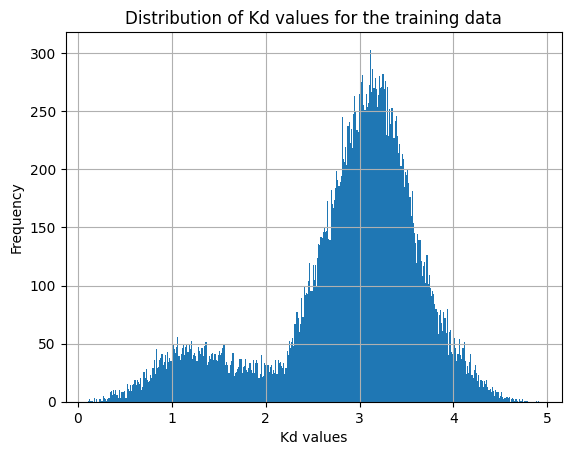

The lower whisker is at: 1.4233289521754073
The upper whisker is at: 4.562420121911141


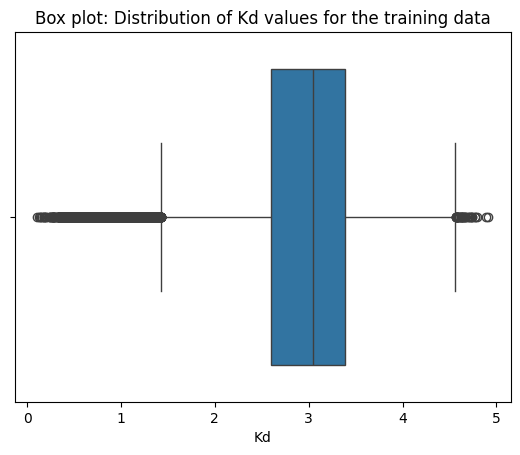

______________________________
we used manual bins


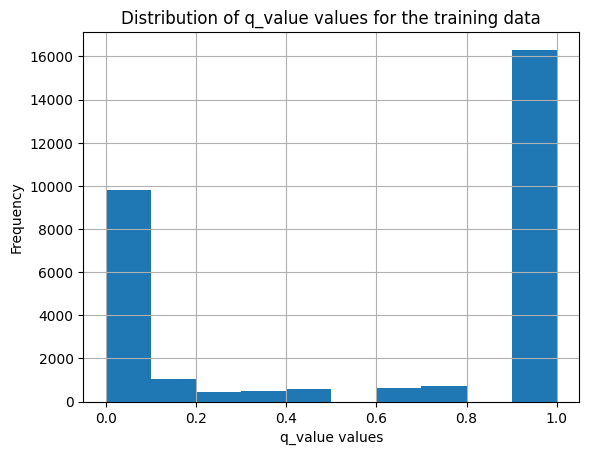

The lower whisker is at: 0.0
The upper whisker is at: 1.0


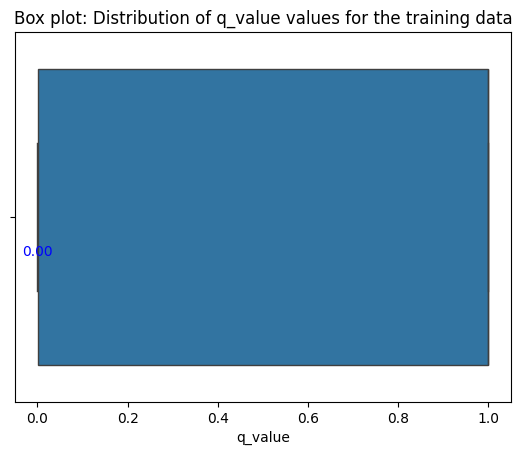

______________________________
we used manual bins


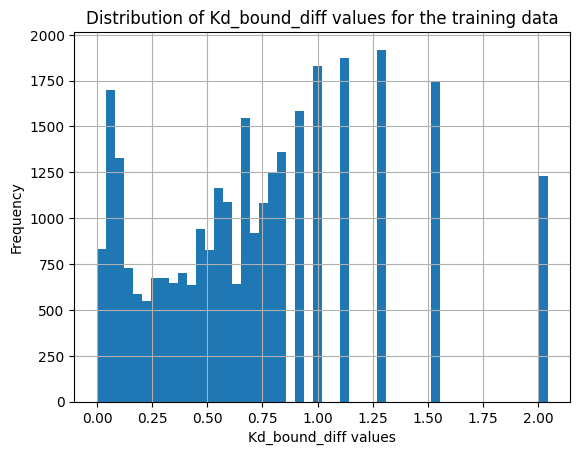

The lower whisker is at: 0.0
The upper whisker is at: 1.9734899480447812


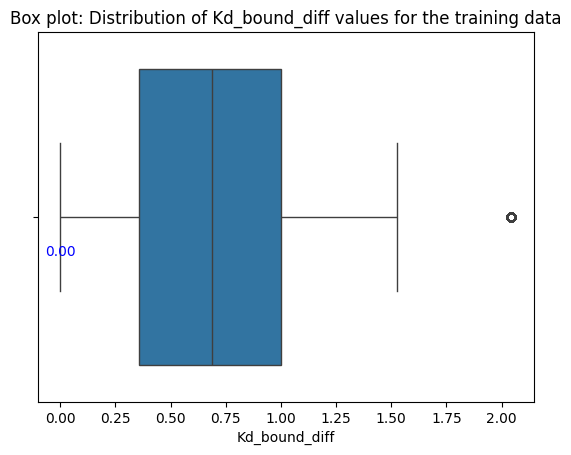

In [8]:
#Create first distribution plots and identify outliers
histogram_plot_distribution(data = training_data, column = 'Kd', bins_manual = 400)
kd_lower_whisker, kd_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'Kd')
print('______________________________')
histogram_plot_distribution(training_data, 'q_value', bins_manual = 10)
q_value_lower_whisker, q_value_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'q_value')
print('______________________________')
histogram_plot_distribution(training_data, 'Kd_bound_diff', bins_manual = 50)
kd_diff_lower_whisker, kd_diff_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'Kd_bound_diff')

### Takeaways from distribution analysis
1) Most Kd values hover around 3, there's a significantly longer and larger low tail shown in the histogram plot. This implies that many of the sequences are binding very well. It would be worth looking at how q_value and Kd correlate. If the exceptionally well binding sequences are only cooccurring with high q_value then these measurements may not be statistically significant
2) Over half of the provided samples are likely to fail the null hypothesis with large q_values. This suggests that we may not be able to trust the Kd measurements for the these sequence interactions as much. 

This quick review of the data suggests that we should rely on the data with sufficiently small q-values and triple check correlation to make sure that Kd and q_value aren't correlated. 

We can also further separate the data by reviewing the inclusion of protein protein binding affinity results based on the variability in Kd bounds

In [9]:
#Lets now label the datapoints within the training set that are Kd, q_value, or Kd_bound_diff outliers

#Number of Kd outliers
training_data['Kd_outlier'] = np.where((training_data['Kd'] < kd_lower_whisker) | (training_data['Kd'] > kd_upper_whisker), 1, 0)
print(len(training_data[training_data['Kd_outlier'] == 1]), '  Kd outliers')
print(len(training_data[training_data['Kd'] < kd_lower_whisker]), '  Kd lower whisker outliers')
print(len(training_data[training_data['Kd'] > kd_upper_whisker]), '  Kd upper whisker outliers')

print('____________________________')

#Number of q_value outliers
training_data['q_value_outlier'] = np.where((training_data['q_value'] < q_value_lower_whisker) | (training_data['q_value'] > q_value_upper_whisker), 1, 0)
print(len(training_data[training_data['q_value_outlier'] == 1]), ' q_value outliers')

print('____________________________')

#Number of Kd_bound_diff outliers
training_data['Kd_bound_diff_outlier'] = np.where((training_data['Kd_bound_diff'] < kd_diff_lower_whisker) | (training_data['Kd_bound_diff'] > kd_diff_upper_whisker), 1, 0)
print(len(training_data[training_data['Kd_bound_diff_outlier'] == 1]), 'k d_bound_diff outliers')
print(len(training_data[training_data['Kd_bound_diff'] < kd_diff_lower_whisker]), '  Kd_bound_diff lower whisker outliers')
print(len(training_data[training_data['Kd_bound_diff'] > kd_diff_upper_whisker]), '  Kd_bound_diff upper whisker outliers')

2677   Kd outliers
2643   Kd lower whisker outliers
34   Kd upper whisker outliers
____________________________
0  q_value outliers
____________________________
1231 k d_bound_diff outliers
0   Kd_bound_diff lower whisker outliers
1231   Kd_bound_diff upper whisker outliers


It seems that there are approximately 2552 Kd outliers and 1231 Kd_bound_diff outliers. The large majority of Kd outliers come from the lower bound whisker. This implies that these proteins may be especially well binding according to Kd meaning. 
All K_bound_diff outlier values are high outliers. This suggests that these are predictions where Kd has a larger level of uncertainty

In [10]:
#Lets check some counts. Are there duplicate descriptions or sequence_a?

unique_sequence_as = len(training_data['sequence_a'].unique())
unique_description_as = len(training_data['description_a'].unique())
unique_sequence_alpha = len(training_data['sequence_alpha'].unique())
unique_description_alpha = len(training_data['description_alpha'].unique())

print('____________________________')
print('There are ' + str(unique_description_as) + ' unique description_a')
print('There are ' + str(unique_sequence_as) + ' unique sequence_a')
print('There are ' + str(unique_sequence_alpha) + ' unique sequence_alpha')
print('There are ' + str(unique_description_alpha) + ' unique description_alpha')
print('____________________________')

#Count of sequence_a per description
description_a_grouped = training_data.groupby('description_a').count()
description_a_counts = description_a_grouped['sequence_a']
description_a_grouped.reset_index(inplace=True)
if any(description_a_counts > 1):
    print('There are ' + str(len(description_a_grouped[description_a_grouped > 1])) + ' description_a with more than 1 sequence_a')
    mult_seqs = description_a_grouped.loc[description_a_grouped['description_a'] > 1, 'sequence_a'].tolist()

sequence_a_grouped = training_data.groupby('sequence_a').count()
sequence_a_counts = sequence_a_grouped['description_a']
sequence_a_grouped.reset_index(inplace=True)
if any(sequence_a_counts > 1):
    print('There are ' + str(len(sequence_a_counts[sequence_a_counts > 1])) + ' sequence_a with more than 1 description')
    #Print out the sequence_as with more than 1 description
    mult_descs = sequence_a_grouped.loc[sequence_a_grouped['description_a'] > 1, 'sequence_a'].tolist()


#Lets mark the sequence_as with mutliple descriptions with a flag
training_data['multiple_desc_a'] = np.where(training_data['sequence_a'].isin(mult_descs), 1, 0)

____________________________
There are 30049 unique description_a
There are 29883 unique sequence_a
There are 1 unique sequence_alpha
There are 1 unique description_alpha
____________________________
There are 105 sequence_a with more than 1 description


## Sequence Analysis
- Now that we've marked the duplicates lets take a closer look at the sequences to see if we can find anything interesting. 


we used manual bins


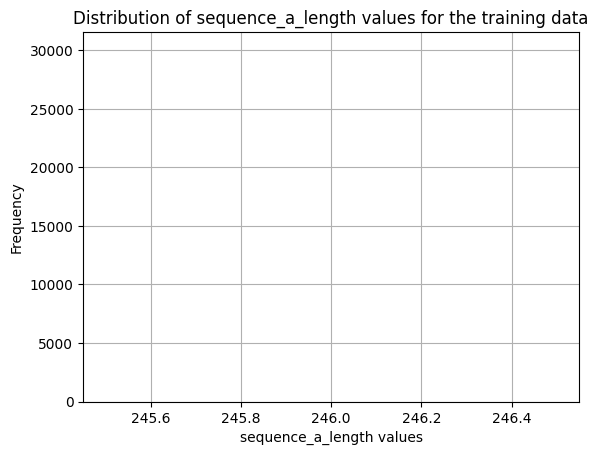

The lower whisker is at: 246.0
The upper whisker is at: 246.0


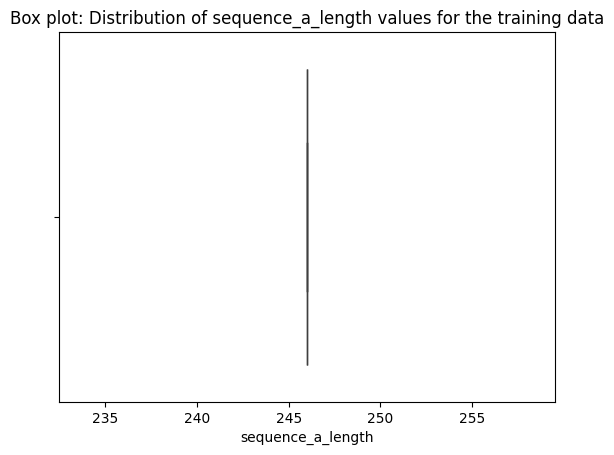

In [11]:
training_data['sequence_a_length'] = training_data['sequence_a'].apply(lambda x: len(x))

#Lets check the distribution of sequence_a lengths
histogram_plot_distribution(data = training_data, column = 'sequence_a_length', bins_manual = 400)
kd_lower_whisker, kd_upper_whisker = boxplot_distribution_outlier_analysis(data = training_data, column = 'sequence_a_length')

Ok, so that was a bit unexpected but it actually makes sense upon second thought! I initially assumed that we were looking at scFv variant of Pembrolizumabthat could differ in length but the instructions explicitly state that we are only looking at a window. The sequence_a values are all the same length because of the window

#Now lets look at the distribution of amino acids per variant



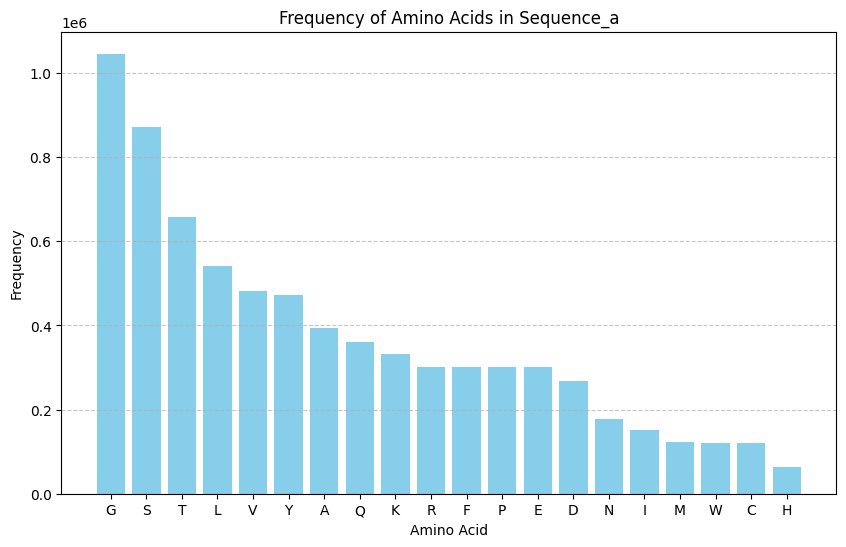

In [12]:
all_sequences_a = ''.join(training_data['sequence_a'])
all_amino_acids= Counter(all_sequences_a)

# Step 2: Create a DataFrame from the counter and plot
freq_df = pd.DataFrame(list(all_amino_acids.items()), columns=['Amino Acid', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(freq_df['Amino Acid'], freq_df['Frequency'], color='skyblue')
plt.title('Frequency of Amino Acids in Sequence_a')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ok, so that provides a list of all the unique amino acids. It also tells us that that most of the AAs are G. This doesn't really tell us much because we can't see a correlation between the sum of the Amino Acids present and the Kd values (or really another numerical value.) I'm curious to see if we can turn the amino acid frequency into a feature that we can use in our models

### Turn Amino Acid Frequency counts into features


In [13]:
ls_of_all_aa_columns = list(all_amino_acids.keys())


def amino_acid_count(sequence, amino_acid):
    return sequence.count(amino_acid)

for aa in list(all_amino_acids.keys()):
    training_data[aa + ' counts'] = training_data['sequence_a'].apply(lambda x: amino_acid_count(x, aa))


We've created many new features. It's time to take a closer look at the correlation between these parameters. This should tell us what may be good features and what may not be good features. We can worry about the data selection later considering we still need to split the data and adjust for the numerous outliers. 

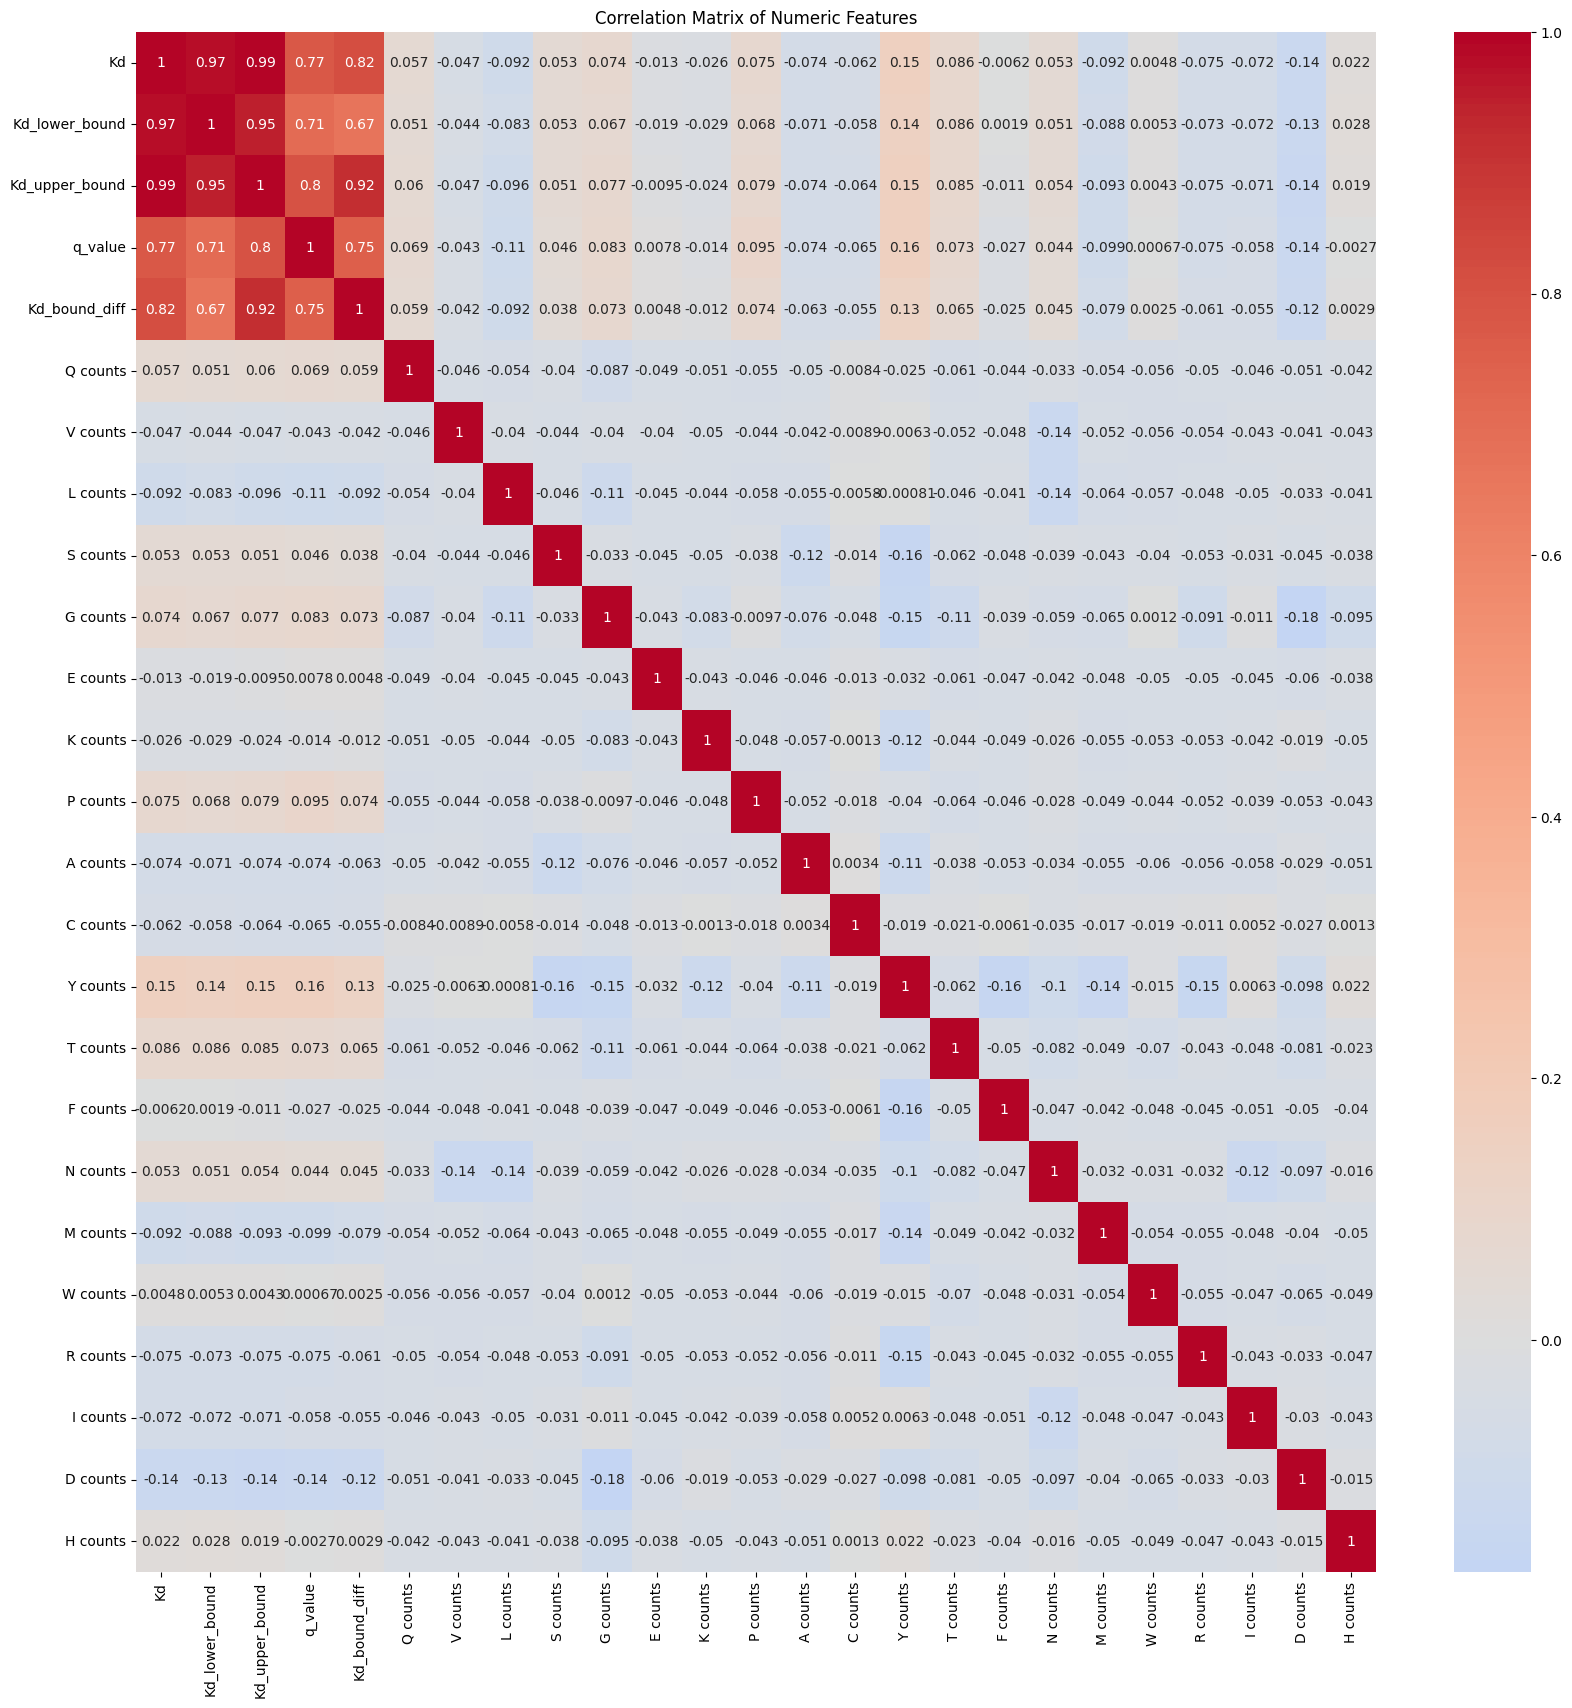

In [14]:
numeric_data = training_data[['Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value', 'Kd_bound_diff',
                            'Q counts', 'V counts', 'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
                            'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
                            'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts']]


plt.figure(figsize = (20,20))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix of Numeric Features')
plt.show()

#### *Major takeaways:*
1) Counts of amino acids per sequence is not strongly correlated with Kd
2) q_value is positively correlated with Kd. **This one is particularly interesting. We were concerned that many of the strongly bound predictions with Kd would be statistically insignificant as illustrated by a high q_value. However, we do not see an inverse correlation here so I don't think that is what is happening.** 
3) We expected to see high correlation between the bounds vs Kd and bounds vs q_value. This makes sense given that the bounds can't differ _TOO_ much from the Kd


## Data Selection
Our experiments above indicate that there are significant numbers of [sequence_a][sequence_alpha] binding experiments that have outlier Kd values or unexpectedly high Kd_bound_diffs. Additionally, we've found instances where the same protein sequences have 2 different Kd values and 2 different descriptions. Personally, I'm the most concerned about instances with less precision in Kd_binding (represented by high Kd_bound_diffs) and the contradictory protein sequences. 

On top of that, the q_value indicated the likelihood that the data included is a false positive. A higher q_value represents a lower chance that the protein binding measurement is distinguishable from the null hypothesis and hance hence biologically irrelevant. 

I'll create datasets that exclude some or all of this information. 

Additionally, since we know that multiple sequence_as have more than one Kd, Kd_lower_bound, Kd_upper_bound, K_bound_diff, and q_value, I'll increlase a pamater that takes the max, min, mean of the values to produce the final data set. 

In [15]:
training_data_slices = {}

#Ok, great now lets create some data slices
def filter_dataset_for_split(data_to_split, 
                            treat_multiple_desc_a = "Max", 
                            ignore_high_q_value = 0.05,
                            ignore_kd_bound_diff = True, 
                            normalize_aa_counts = "MinMax",
                            list_of_aa_columns = []):
    #Ignore_high_q_value must be a float type data or False
    #We only ignore kd_bound_diff interactions if the value is high, this represents unexpectedly high variablility in Kd values
    #We can use this step to normalize 

    data = data_to_split.copy()

    if treat_multiple_desc_a:
        
        columns_to_transform = ['Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'Kd_bound_diff', 'q_value']
        for column in columns_to_transform:
            if treat_multiple_desc_a == "Max":
                data[column] = data.groupby('sequence_a')[column].transform('max')
            elif treat_multiple_desc_a == "Min":
                data[column] = data.groupby('sequence_a')[column].transform('min')
            elif treat_multiple_desc_a == "Avg":
                data[column] = data.groupby('sequence_a')[column].transform('mean')
            else:
                raise ValueError("Incorrect aggregation method used")

            
    else:
        print("we won't consider any sequences with multiple descriptions")
        data = data.loc[data['multiple_desc_a'] == 0, :]

        
    if ignore_high_q_value:
        data = data.loc[data['q_value'] < ignore_high_q_value, :]
    if ignore_kd_bound_diff:
        data = data.loc[data['Kd_bound_diff_outlier'] == 0,:]

    #We don't have to worry about the duplicates here because the sequences that are duplicates have the same AA count. 
    if normalize_aa_counts == "MinMax" and list_of_aa_columns:
        #We have 2 options for normalization: MinMaxScaling or using the StandardScaler
        scaler = preprocessing.MinMaxScaler()
        data[list_of_aa_columns] = scaler.fit_transform(data[list_of_aa_columns])
    elif normalize_aa_counts == 'Standard' and list_of_aa_columns:
        #We have 2 options for normalization: MinMaxScaling or using the StandardScaler
        scaler = preprocessing.StandardScaler()
        data[list_of_aa_columns] = scaler.fit_transform(data[list_of_aa_columns])
    elif not list_of_aa_columns:
        print("error submit aa_columns")
        return data

    return data

ls_aa_columns = [x for x in list(training_data.columns) if 'counts' in x ]

#NOTE Threshold for q_value exclusion is empirically determined
parameters_dictionary = [
                        {'include_all_q_values_MinMax':{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : False, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"MinMax"},
                         "exclude_high_q_values_MinMax":{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : 0.05, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"MinMax"},
                         'include_all_q_values_StandardScaler':{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : False, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"Standard"},
                         'exclude_all_q_values_StandardScaler':{'treat_multiple_desc_a' : "Max", "ignore_high_q_value" : 0.05, "ignore_kd_bound_diff" : True, "normalize_aa_counts":"Standard"}}
                        ]

for param_dict in parameters_dictionary:
    for k,v in param_dict.items():
        treat_multiple_desc_a = v.get('treat_multiple_desc_a')
        ignore_high_q_value = v.get('ignore_high_q_value')
        ignore_kd_bound_diff = v.get('ignore_kd_bound_diff')
        normalize_aa_counts = v.get('normalize_aa_counts')
        training_data_slices[k] = filter_dataset_for_split(data_to_split = training_data,
                                                        treat_multiple_desc_a = treat_multiple_desc_a,
                                                        ignore_high_q_value=ignore_high_q_value,
                                                        normalize_aa_counts=normalize_aa_counts, 
                                                        list_of_aa_columns = ls_aa_columns)
                                                        


for k,v in training_data_slices.items():
    print(v.shape[0] , ' ------ sequences included when for {data_name}'.format(data_name = k))

28818  ------ sequences included when for include_all_q_values_MinMax
9293  ------ sequences included when for exclude_high_q_values_MinMax
28818  ------ sequences included when for include_all_q_values_StandardScaler
9293  ------ sequences included when for exclude_all_q_values_StandardScaler


### There are significantly fewer examples of sequences if we exclude all the high q values (especially if threshold set at standard 0.05)

In [16]:
#check for any nukll values in Kd again before modelling
any(x for x in training_data_slices['include_all_q_values_MinMax']['Kd'].isnull())

#check for inconsistet data types
all(isinstance(x, float) for x in training_data_slices['include_all_q_values_MinMax']['Kd'])


True

### Dataset Creation for Dataloaders.
- Enable users to select their own encoding representation method 
    - One-hot-encoding
    - Embedding layers (relying on learned indices representation)
    


#### Separate data into datasets for the different training data slices


In [17]:

# Stratification presents an interesting opportunity. We could stratify according to q-value or the K-bound_diff values, this would presumbly make our dataset more effective at predicting only statistically significant protein-protein interactions.
# However, since we'll be predicting on a hold out set with no q_value for measured data it only affect training score not really our "test".
# We'll hold off on stratification for now but I think we should revisit it. 
batch_size = 64
aa_values = ['Q counts', 'V counts',
       'L counts', 'S counts', 'G counts', 'E counts', 'K counts', 'P counts',
       'A counts', 'C counts', 'Y counts', 'T counts', 'F counts', 'N counts',
       'M counts', 'W counts', 'R counts', 'I counts', 'D counts', 'H counts']

x_values = ['sequence_a'] + aa_values

segmented_datasets_for_training = {}

for k,v in training_data_slices.items():
      
      sequences = np.array(v['sequence_a']) #turn series to np.array
      labels = np.array(v['Kd']) #turn series to np.array
      aa_features_tensor = torch.tensor(v[aa_values].to_numpy())

      #Create datasets with different kinds of encodings for sequencing
      dataset_embedding = modelling_utilities.SequenceKdDataset(sequences = sequences, features = aa_features_tensor,  labels = labels, encoding_type="embeddings") 
      dataset_one_hot = modelling_utilities.SequenceKdDataset(sequences = sequences, features = aa_features_tensor,  labels = labels, encoding_type="one_hot") 

      #When using cross-val, we create dataloaders for the model within the training loop
      segmented_datasets_for_training[k + "_embeddings"] = {'full_dataset':dataset_embedding}
      segmented_datasets_for_training[k + "_one_hot"] = {'full_dataset':dataset_one_hot}



/Users/cody_schiffer/job_hunt_2024/coding_challenges/a_alpha_bio/modelling_utilities.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/Users/cody_schiffer/job_hunt_2024/coding_challenges/a_alpha_bio/modelling_utilities.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/Users/cody_schiffer/job_hunt_2024/coding_challenges/a_alpha_bio/modelling_utilities.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.featu

### Sample Inspection of Training data slices and gather the length of the encoded sequence
- We'll also use this to gather data lengths for the model

In [18]:

sample_dataset = segmented_datasets_for_training['include_all_q_values_MinMax_one_hot']['full_dataset']

for i, (sequences, aa_features, labels) in enumerate(sample_dataset):
    print(f"Batch {i+1}")
    print("Sequences Shape:", sequences.shape)
    print("Features Shape:", aa_features.shape)
    print("Labels Shape:", labels.shape)
    
    print("Sample Sequences:", sequences)  # Show the first sequence of the batch
    print("Sample AA Features:", aa_features)    # Show the first set of features of the batch
    print("Sample Labels:", labels)        # Show the first label of the batch

    
    if i == 0:  # Limit to printing details for the first two batches only
        break


encoded_sequence_length = len(sequences)


Batch 1
Sequences Shape: torch.Size([246, 20])
Features Shape: torch.Size([20])
Labels Shape: torch.Size([])
Sample Sequences: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Sample AA Features: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        1.0000, 0.5000, 0.6000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.3333,
        0.5000, 0.0000])
Sample Labels: tensor(2.1768)


## Modelling

### Defining the model architectures
- We will pursue 2 deep learning approaches:
    - CNN based vs CNN + TransformerArchitecture
    - Each model will include methods for using additional features (like amino acid frequencies)
    - Each model will include the option to evaluate 
    
- We will choose features, scaling type based on initial CNN experiments
- Architectures can be found in model_architectures.py



### Model Utilities found ing modelling_utilities.py

- validation
- early stopping
- get_data_loaders_per_kf



### Define the training loop

In [70]:
def training_loop(**kwargs):

    
    data_slices = kwargs.get('data_slices', [])
    num_epochs = kwargs.get('num_epochs', 10)
    device = kwargs.get('device', None)
   
    #Pass the model config dictionary necessary for model instantiation
    model_config_dict = kwargs.get('model_config_dict', {})

    #Cross_validation 
    n_folds = kwargs.get('n_folds', 5)
    batch_size = kwargs.get('batch_size', 64)

    #early stopping
    patience = kwargs.get('patience', 10)

    #Random_Seed
    random_seed = kwargs.get('random_seed', 15)

    #Kfold definition
    kfold_structure = kwargs.get('kfold_structure', KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)) 


    
    if not data_slices:
        raise ValueError('No training data slices provided')

    kfold_epoch_metrics ={}

    for pos, items in enumerate(data_slices.items()):
        k = items[0]
        v = items[1]



        print('-------- Dataset: ', k, '--------')
       
        history = {
                    'train_loss': [],
                    'val_loss': [],
                    'train_r2':[],
                    'val_r2':[],
                    'train_mae':[],
                    'val_mae':[],
                    'train_rmse':[],
                    'val_rmse':[]
                }

        kfold_epoch_metrics[k] = {}

        #Define epoch metrics per kfold per training_slice
        for metric in ['train_loss', 'val_loss', 'train_r2', 'val_r2', 'train_mae', 'val_mae', 'train_rmse', 'val_rmse']:
            kfold_epoch_metrics[k][metric] = {}
            for fold in range(n_folds):
                kfold_epoch_metrics[k][metric][str(fold) + '_fold'] = []

      
        print(kfold_epoch_metrics, ' ---- these are the epoch metrics for storage')

        print('using cross val')

        dataset= v.get('full_dataset', None)
        
        if not dataset:
            raise ValueError('No full dataset provided in loop')

        for fold_idx in range(n_folds):
            print(fold_idx, ' ---- this is the fold index')

            #Early stopping definition
            early_stopping = early_stopping = modelling_utilities.EarlyStopping(patience=patience, verbose=True, path='model_checkpoint.pt')
            
            train_loader, val_loader = modelling_utilities.get_data_loaders_per_kfold(full_dataset = dataset, fold_idx = fold_idx,batch_size = batch_size, kfold_structure = kfold_structure)
            print('We are at Kfold index: ', fold_idx)

            #RE-instantiate the model
           
            model, model_name, optimizer, loss_measurement, device = modelling_utilities.cnn_model_instantiation(model_config_dict)

            #RE-instantiate the model
            print(f'{model_name}_DataSlice(' + k + ')_')
            
            print ('___________________')
            print('Model_Architecture: ')
            print(model )

            for epoch in range(num_epochs+1):
                start_time = time.time()
                
                if epoch %2 == 0:
                    print('We are at epoch: ' + str(epoch))

                model.train()
                all_batch_train_loss = 0
                batch_samples = 0

                all_train_preds = []
                all_train_labels = []
                all_val_preds = []
                all_val_labels = []

            
                for pos, batch in enumerate(train_loader):
                    

                    if pos == 0 and epoch == 0:  # Just print the first batch to inspect
                        if len(batch) == 3:
                            print("Batch structure is correct: (seqs, features, labels)")
                        else:
                            print("Batch structure incorrect:", batch)
                        

                    seqs = batch[0]
                    features = batch[1]
                    labels = batch[2]


                    seqs = seqs.to(device)
                    features = features.to(device)
                    labels = labels.to(device)

                    # print("Data type of sequences:", seqs.dtype)
                    # print(features, ' ---- these are the features')
                    # print("Data type of features:", features.dtype)

                    # Forward pass
                    outputs = model(x = seqs,
                                    additional_features = features)  # Adjust dimensions for Conv1D
                    
                    all_train_preds.append(outputs.detach())
                    all_train_labels.append(labels)

                    # Backward pass and optimization
                    loss = loss_measurement(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    
                    #Add loss per batch and normalize per batch size
                    all_batch_train_loss += loss.item() * seqs.size(0)
                    batch_samples += seqs.size(0)

                avg_batch_training_loss = all_batch_train_loss / batch_samples
                
                
                # Validate after each epoch
                avg_validation_loss, epoch_val_preds, epoch_val_labels = modelling_utilities.validate(val_model = model,
                                                                            val_loader = val_loader,
                                                                            loss_measurement = loss_measurement )
                
                early_stopping(avg_validation_loss, model)

                #Implement early stopping
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    break

                # Converting lists to tensors
                train_preds = torch.cat(all_train_preds)
                train_labels = torch.cat(all_train_labels)
                val_preds = torch.cat(epoch_val_preds)
                val_labels = torch.cat(epoch_val_labels)

                # Calculate metrics for training
                # Compute final metrics for epoch
                train_r2 = r2_score(train_labels.numpy(), train_preds.numpy())
                val_r2 = r2_score(val_labels.numpy(), val_preds.numpy())
                train_mae = mean_absolute_error(train_labels.numpy(), train_preds.numpy())
                val_mae = mean_absolute_error(val_labels.numpy(), val_preds.numpy())
                train_rmse = root_mean_squared_error(train_labels.numpy(), train_preds.numpy())
                val_rmse = root_mean_squared_error(val_labels.numpy(), val_preds.numpy())


                # Store metrics per epoch across folds
                for metric, value in zip(['train_loss', 'val_loss', 'train_r2', 'val_r2', 'train_mae', 'val_mae', 'train_rmse', 'val_rmse'],
                                        [avg_batch_training_loss, avg_validation_loss, train_r2, val_r2, train_mae, val_mae, train_rmse, val_rmse]):
                    kfold_epoch_metrics[k][metric][str(fold_idx) + '_fold'].append(value)
                end_time = time.time()



                #Printing time records of the epochs
                if epoch %2 == 0:
                    print(end_time - start_time, '- time to  finish one epoch')


        #Store the models
        try:
            # Construct the file path for saving the model results
            models_saving_path = f'./models/{model_name}/{model_name}_model_Training_Slice_{k}_Fold({fold_idx}).pt'
            
            # Create the directory if it doesn't exist
            os.makedirs(os.path.dirname(models_saving_path), exist_ok=True)
            
            #Save the model state dict
            torch.save(model.state_dict(), models_saving_path)
            
        except Exception as e:
            print(e, ' ---- error saving the model')
            pass

    #Store the results
    try:
        # Construct the file path for saving the model results
        model_results_path = f'./model_results/{model_name}/{model_name}_model_Training_Slice_{k}.json'
        
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(model_results_path), exist_ok=True)
        
        # Open the file in write mode and dump the dictionary into it as JSON
        with open(model_results_path, 'w') as file:
            json.dump(kfold_epoch_metrics, file)
       
    except Exception as e:
        print(e, ' ---- rror saving the results')
        pass

    return kfold_epoch_metrics

IndentationError: expected an indented block after 'try' statement on line 188 (4233232913.py, line 190)

***

### Run Baseline Deeplearning Models
- For simplicity and to reduce the possibility of data leakage and inadvertant transfer learning we will run each data slice one at time. 
- This is also helpful for examining code outputs and debugging. 
- A future improvement where all dataslices are looped through iteratively is possible with minor adjustments. However, for exploratory work this will sufice. 

The objective of this sections is to identify which CNN architecture and data features have the highest performance. Then we can work on hyperparameter optimization and adding a transformer on top of it. 

Each Run consistents of 2 sections:
- Section A - Model instantiation and training loop
- Section B - Results evaluation

All models are saved to the .models/folder

Our objective is to get the model with the overall strongest performance across metrics across folds. We will use that for the hold out set. 

***

#### **Baseline Model shared parameters**


In [49]:
batch_size = 64
n_folds = 2
num_epochs = 20
patience = 10

****

#### 1. Run 1 - One Hot encoding with no amino acid frequency data included


*Section A*

In [39]:
#Define the model name
model_name = "ProteinCNN_One_Hot_Encoding_No_AA_No_DropOut"

sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = False
use_embedding= False
use_dropout = False
conv_dropout = 0.2

embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

#Optimizer
lr_rate = 0.001
L2_reg = 1e-5

#Model config dict for instantiating model during kfolds within training loop
model_config_dict = {
    'prediction_architecture': model_architectures.ProteinKd_CNN_Prediction,
    'sequence_length': encoded_sequence_length,  
    'num_additional_features': len(aa_values),  
    'use_aa_features': use_aa_features,
    'use_embedding': use_embedding,
    'use_dropout': use_dropout,
    'conv_dropout': conv_dropout,
    'embedding_dimension': embedding_dimension,
    'conv_layer_kernel_size': conv_layer_kernel_size,
    'pooling_kernel_size': pooling_kernel_size,
    'pool_stride': pool_stride,
    'conv_stride': conv_stride,
    'conv_padding': conv_padding,
    'conv_dilation': conv_dilation,
    'lr_rate': lr_rate,
    'L2_reg': L2_reg,
    'model_name' : model_name 
}

model, model_name, optimizer, loss_measurement, device = modelling_utilities.cnn_model_instantiation(model_config_dict)

print(model)

61 ---- output size prior to final calculation
15616 ---- this is the final input size going into the linear layer
---- ProteinCNN_One_Hot_Encoding_No_AA_No_DropOut Model built ----
ProteinKd_CNN_Prediction(
  (layers): Sequential(
    (0): Conv1d(20, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fullyconnected): Sequential(
    (0): Linear(in_features=15616, out_features=128, bias=True)
    (1): ReLU()
    (2): Identity()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [41]:
segmented_datasets_for_training


{'include_all_q_values_MinMax_embeddings': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce53188490>},
 'include_all_q_values_MinMax_one_hot': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce37f68ee0>},
 'exclude_high_q_values_MinMax_embeddings': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce35faee30>},
 'exclude_high_q_values_MinMax_one_hot': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce35fadcc0>},
 'include_all_q_values_StandardScaler_embeddings': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce35fae8f0>},
 'include_all_q_values_StandardScaler_one_hot': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce35faded0>},
 'exclude_all_q_values_StandardScaler_embeddings': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce35fadbd0>},
 'exclude_all_q_values_StandardScaler_one_hot': {'full_dataset': <modelling_utilities.SequenceKdDataset at 0x7fce35fac100>}}

In [50]:
sample_run = {k:v for k,v in segmented_datasets_for_training.items() if k in ['exclude_all_q_values_StandardScaler_one_hot']}

# Usage in your training loop:
kfold_structure = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

model_results = training_loop(data_slices = sample_run,
                                num_epochs =num_epochs,
                                batch_size = batch_size, 
                                use_cross_val = True, 
                                random_seed = random_seed,
                                kfold_structure = kfold_structure, 
                                patience = patience,
                                n_folds = n_folds,
                                model_name = model_name,
                                model_config_dict = model_config_dict
                                )



            

-------- Dataset:  exclude_all_q_values_StandardScaler_one_hot --------
{'exclude_all_q_values_StandardScaler_one_hot': {'train_loss': {'0_fold': [], '1_fold': []}, 'val_loss': {'0_fold': [], '1_fold': []}, 'train_r2': {'0_fold': [], '1_fold': []}, 'val_r2': {'0_fold': [], '1_fold': []}, 'train_mae': {'0_fold': [], '1_fold': []}, 'val_mae': {'0_fold': [], '1_fold': []}, 'train_rmse': {'0_fold': [], '1_fold': []}, 'val_rmse': {'0_fold': [], '1_fold': []}}}  ---- these are the epoch metrics for storage
using cross val
0  ---- this is the fold index
We are at Kfold index:  0
61 ---- output size prior to final calculation
15616 ---- this is the final input size going into the linear layer
---- ProteinCNN_One_Hot_Encoding_No_AA_No_DropOut Model built ----
ProteinCNN_One_Hot_Encoding_No_AA_No_DropOut_DataSlice(exclude_all_q_values_StandardScaler_one_hot)_
___________________
Model_Architecture: 
ProteinKd_CNN_Prediction(
  (layers): Sequential(
    (0): Conv1d(20, 128, kernel_size=(3,), stri

*Section B*

In [53]:
avg_score_per_fold, avg_score_per_metric, max_score_per_metric = modelling_utilities.post_process_epoch_metrics(model_results)
print(max_score_per_metric, f' ---- max scores across all folds per metric {model_name}')


{'exclude_all_q_values_StandardScaler_one_hot': {'train_loss': 0.35219292683931747, 'val_loss': 0.36066735761901686, 'train_r2': 0.3002143478526974, 'val_r2': 0.2833403509322915, 'train_mae': 0.48627537, 'val_mae': 0.49176908, 'train_rmse': 0.5827159, 'val_rmse': 0.59327114}}  ---- max scores across all folds per metric ProteinCNN_One_Hot_Encoding_No_AA_No_DropOut


In [54]:
CreatePlots = PlottingAssistance(n_folds = n_folds, metrics =['r2', 'mae', 'rmse', 'loss'])

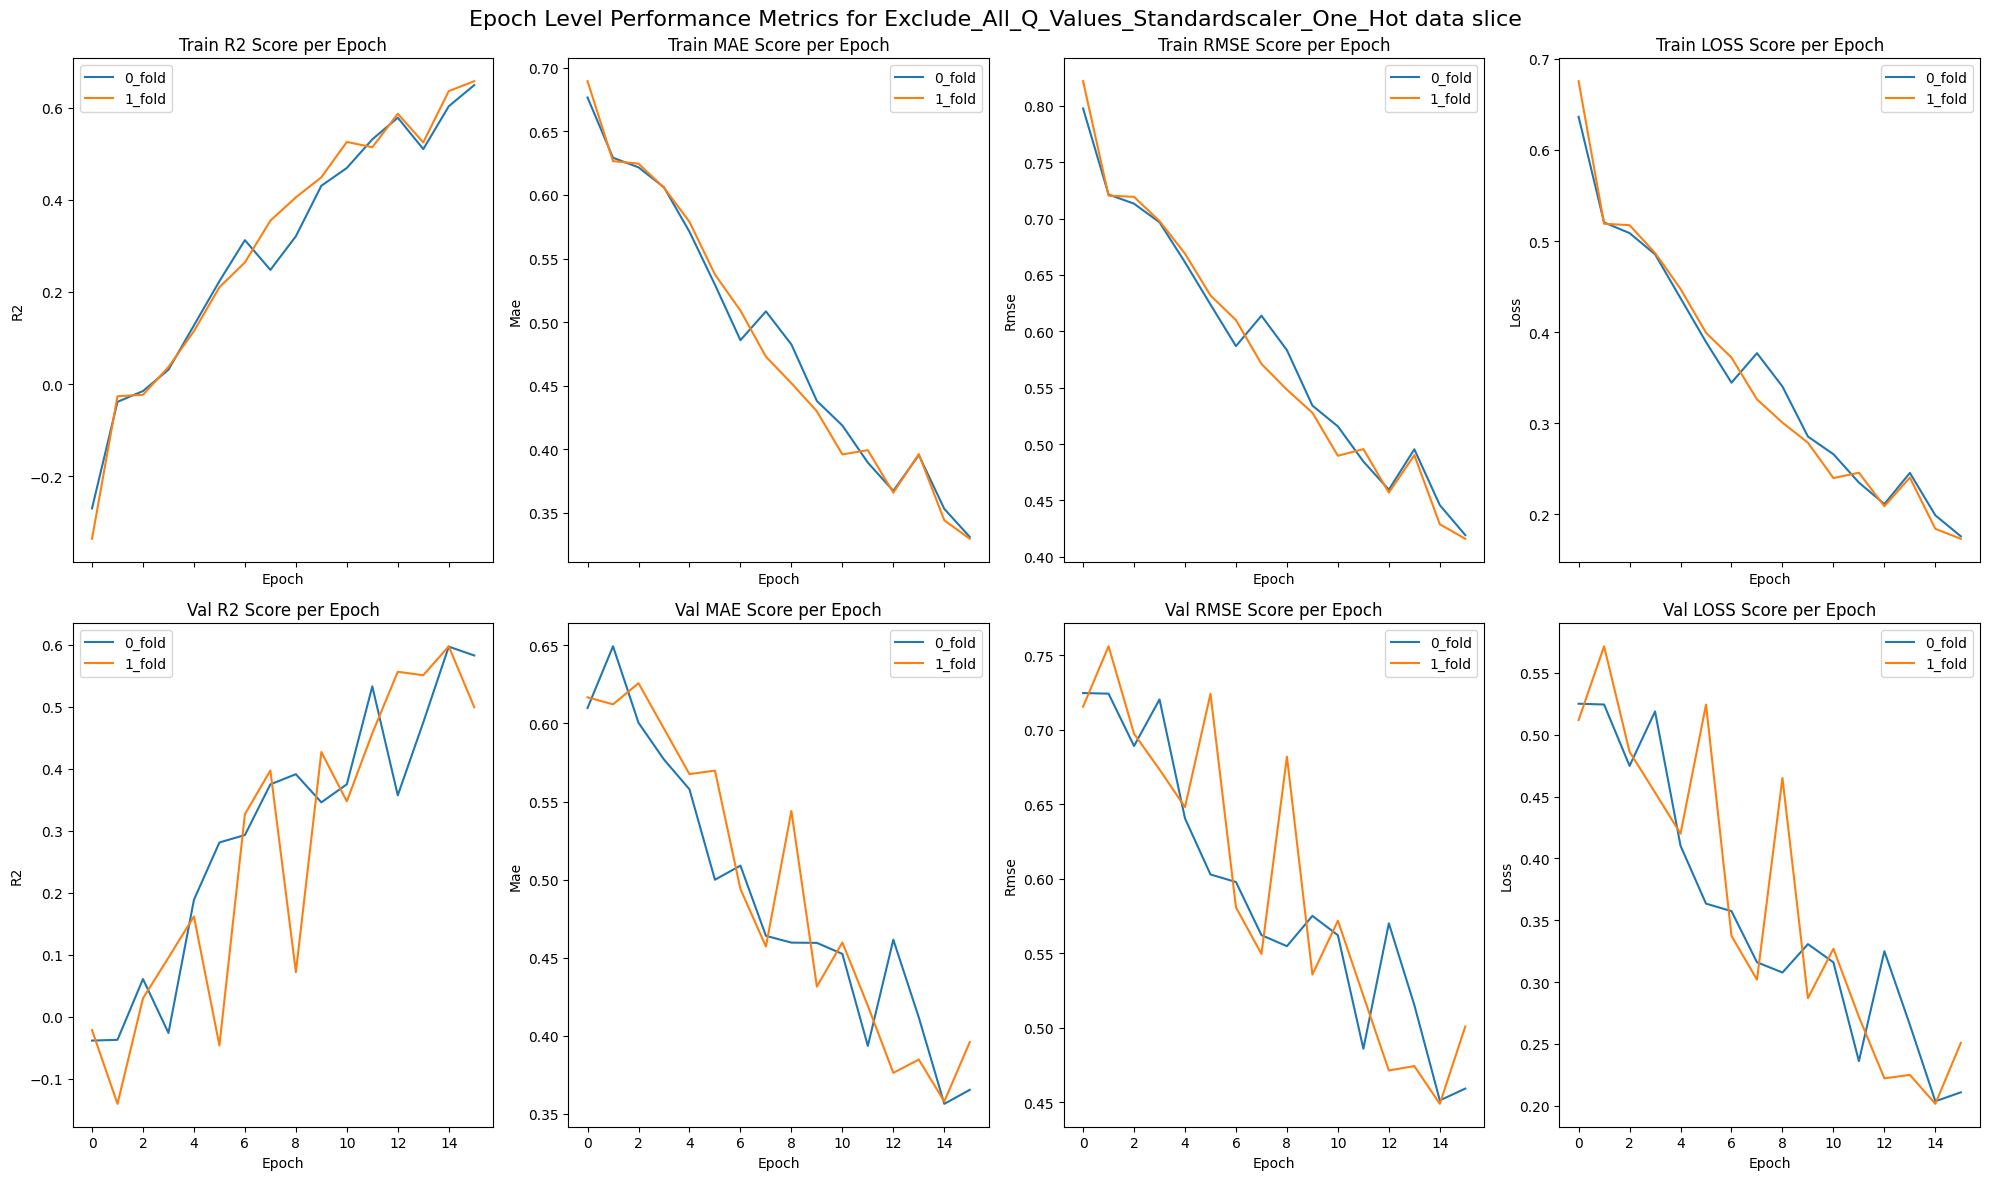

In [55]:
CreatePlots.epoch_performance_per_fold(model_results = model_results)

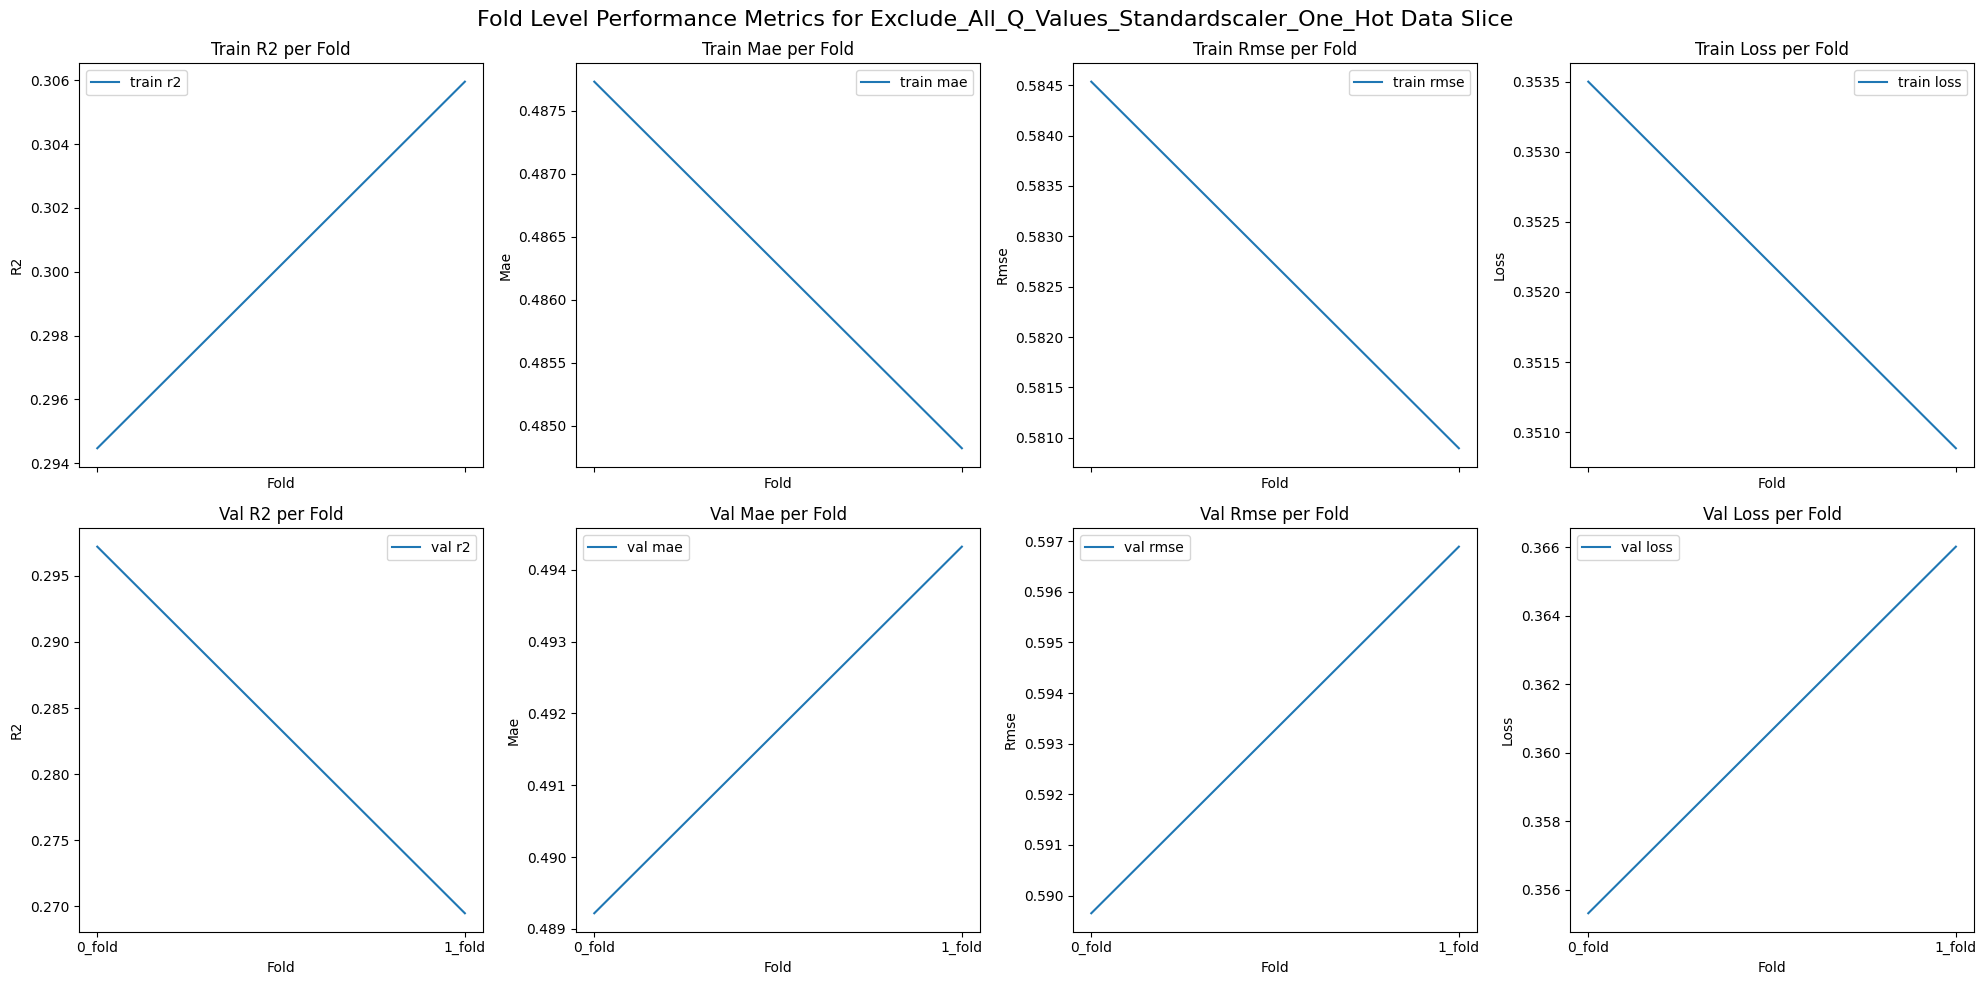

In [56]:
CreatePlots.fold_level_performance(avg_score_per_fold = avg_score_per_fold)

****

### Run 2)  Embeddings w/ no AA and no Dropout
- this will tell us whether embeddings or one hot encoding are better suited for future research

*Section A*

In [64]:
#Define the model name
model_name = "ProteinCNN_Embedding_No_AA_No_Dropout"

sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = False
use_embedding= True
use_dropout = False
conv_dropout = 0.2

embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

#Optimizer
lr_rate = 0.001
L2_reg = 1e-5


#Model config dict for instantiating model during kfolds within training loop
model_config_dict = {
    'prediction_architecture': model_architectures.ProteinKd_CNN_Prediction,
    'sequence_length': encoded_sequence_length,  
    'num_additional_features': len(aa_values),  
    'use_aa_features': use_aa_features,
    'use_embedding': use_embedding,
    'use_dropout': use_dropout,
    'conv_dropout': conv_dropout,
    'embedding_dimension': embedding_dimension,
    'conv_layer_kernel_size': conv_layer_kernel_size,
    'pooling_kernel_size': pooling_kernel_size,
    'pool_stride': pool_stride,
    'conv_stride': conv_stride,
    'conv_padding': conv_padding,
    'conv_dilation': conv_dilation,
    'lr_rate': lr_rate,
    'L2_reg': L2_reg,
    'model_name' : model_name 
}

model, model_name, optimizer, loss_measurement, device = modelling_utilities.cnn_model_instantiation(model_config_dict)

print(model)

61 ---- output size prior to final calculation
15616 ---- this is the final input size going into the linear layer
---- ProteinCNN_Embedding_No_AA_No_Dropout Model built ----
ProteinKd_CNN_Prediction(
  (embedding): Embedding(20, 64)
  (layers): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fullyconnected): Sequential(
    (0): Linear(in_features=15616, out_features=128, bias=True)
    (1): ReLU()
    (2): Identity()
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [65]:
sample_run = {k:v for k,v in segmented_datasets_for_training.items() if k in ['exclude_high_q_values_MinMax_embeddings', 'exclude_all_q_values_StandardScaler_embeddings']}
# Usage in your training loop:

kfold_structure = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

model_results = training_loop(data_slices = sample_run,
                                                    num_epochs =num_epochs,
                                                    submitted_model = model,
                                                    loss_measurement = loss_measurement,
                                                    optimizer = optimizer,
                                                    device = device,
                                                    batch_size = batch_size, 
                                                    use_cross_val = True, 
                                                    random_seed = random_seed,
                                                    kfold_structure = kfold_structure, 
                                                    patience = patience,
                                                    n_folds = n_folds, 
                                                    model_name = model_name, 
                                                    model_config_dict = model_config_dict)

-------- Dataset:  exclude_high_q_values_MinMax_embeddings --------
{'exclude_high_q_values_MinMax_embeddings': {'train_loss': {'0_fold': [], '1_fold': []}, 'val_loss': {'0_fold': [], '1_fold': []}, 'train_r2': {'0_fold': [], '1_fold': []}, 'val_r2': {'0_fold': [], '1_fold': []}, 'train_mae': {'0_fold': [], '1_fold': []}, 'val_mae': {'0_fold': [], '1_fold': []}, 'train_rmse': {'0_fold': [], '1_fold': []}, 'val_rmse': {'0_fold': [], '1_fold': []}}}  ---- these are the epoch metrics for storage
using cross val
0  ---- this is the fold index
We are at Kfold index:  0
61 ---- output size prior to final calculation
15616 ---- this is the final input size going into the linear layer
---- ProteinCNN_Embedding_No_AA_No_Dropout Model built ----
ProteinCNN_Embedding_No_AA_No_Dropout_DataSlice(exclude_high_q_values_MinMax_embeddings)_
___________________
Model_Architecture: 
ProteinKd_CNN_Prediction(
  (embedding): Embedding(20, 64)
  (layers): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,

*Section B*

In [66]:
avg_score_per_fold, avg_score_per_metric, max_score_per_metric = modelling_utilities.post_process_epoch_metrics(model_results)
print(max_score_per_metric, f' ---- max scores across all folds per metric {model_name}')

{'exclude_high_q_values_MinMax_embeddings': {'train_loss': 0.3436422850483723, 'val_loss': 0.3641187947700698, 'train_r2': 0.31718752474866546, 'val_r2': 0.276638975471996, 'train_mae': 0.4740888, 'val_mae': 0.49703154, 'train_rmse': 0.57347643, 'val_rmse': 0.5964256}, 'exclude_all_q_values_StandardScaler_embeddings': {'train_loss': 0.36417219538777224, 'val_loss': 0.3596387668463694, 'train_r2': 0.27645331670590456, 'val_r2': 0.2853249942292318, 'train_mae': 0.48187888, 'val_mae': 0.49409932, 'train_rmse': 0.58547866, 'val_rmse': 0.5924997}}  ---- max scores across all folds per metric ProteinCNN_Embedding_No_AA_No_Dropout


In [67]:
CreatePlots = PlottingAssistance(n_folds = n_folds, metrics =['r2', 'mae', 'rmse', 'loss'])

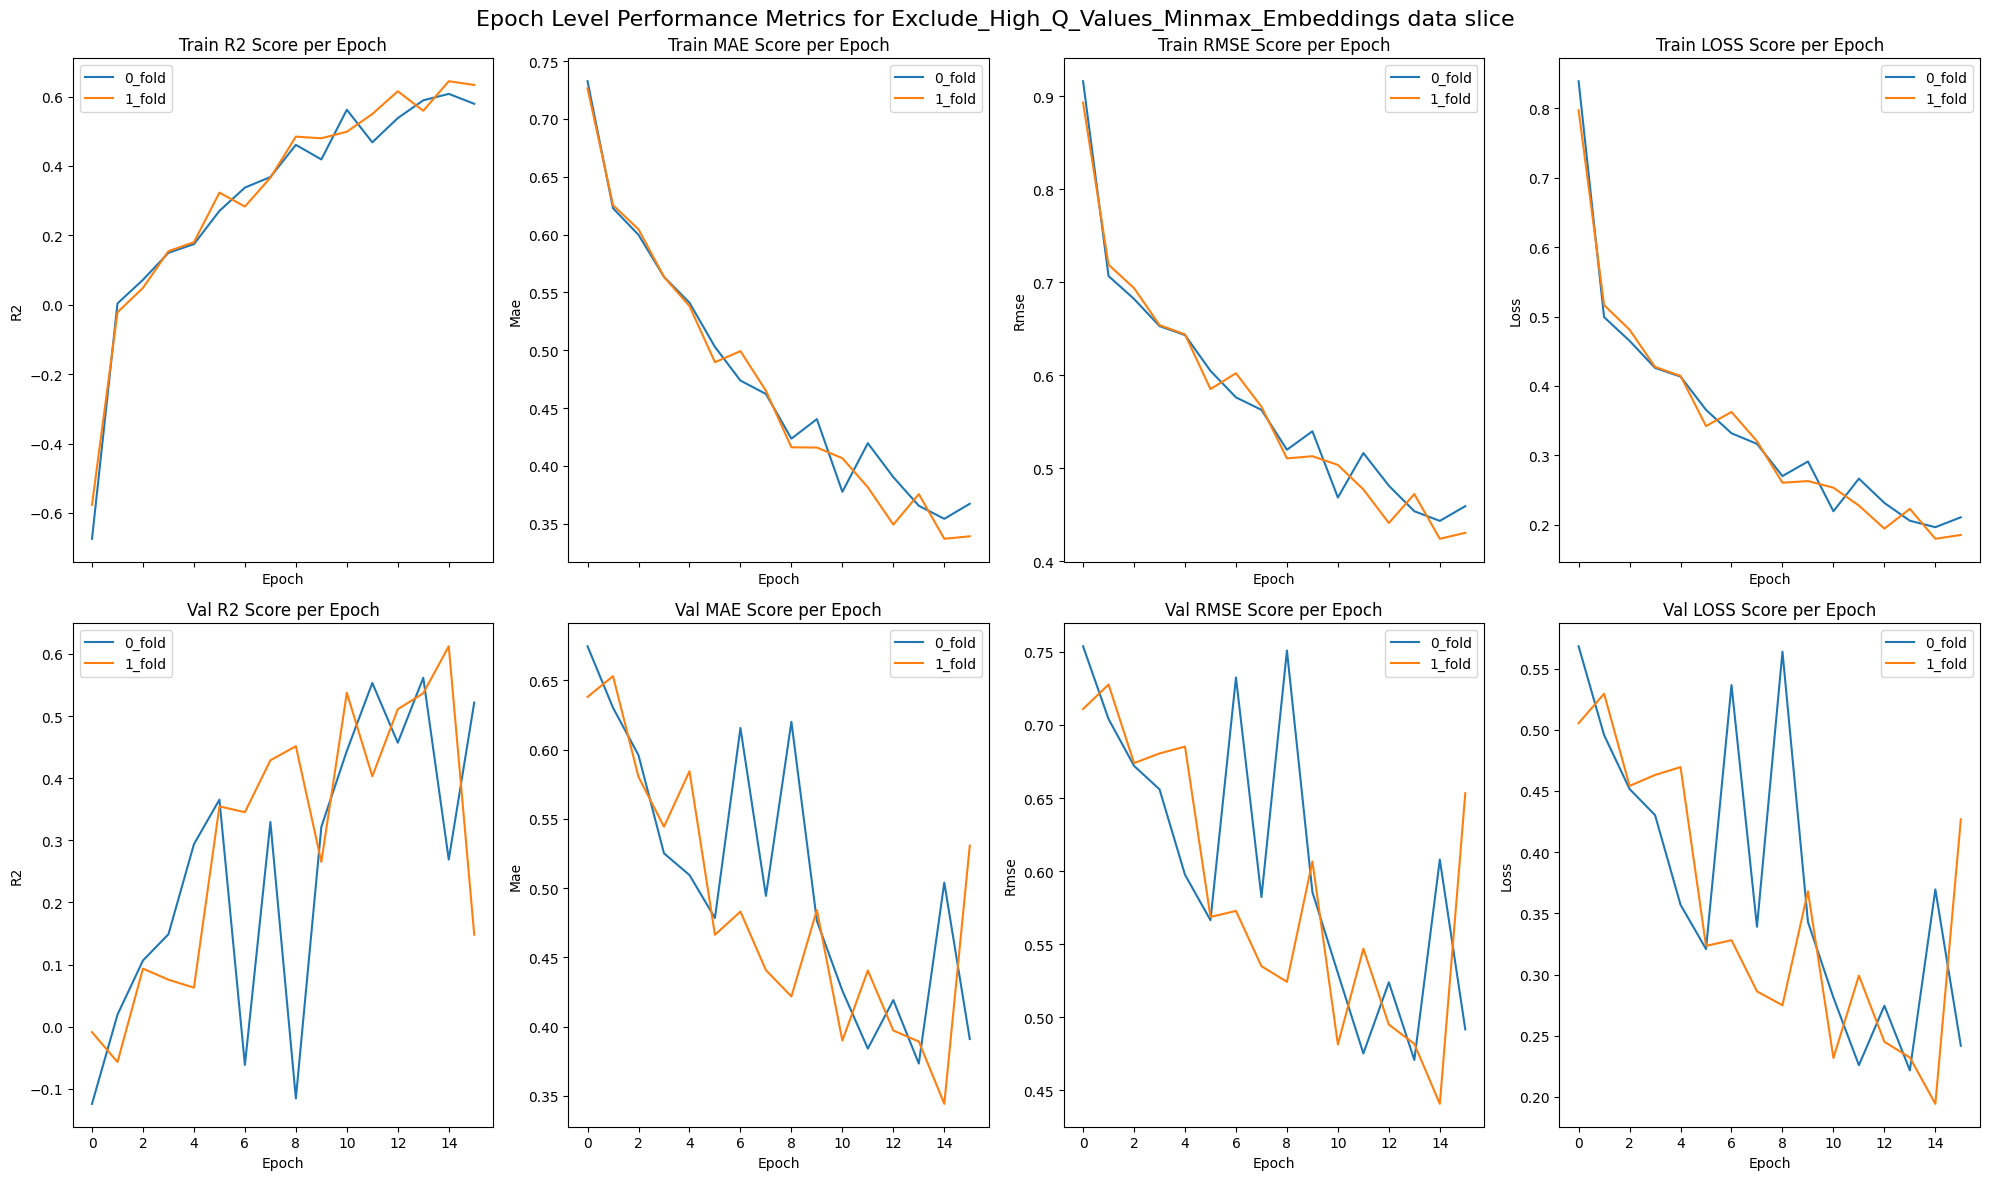

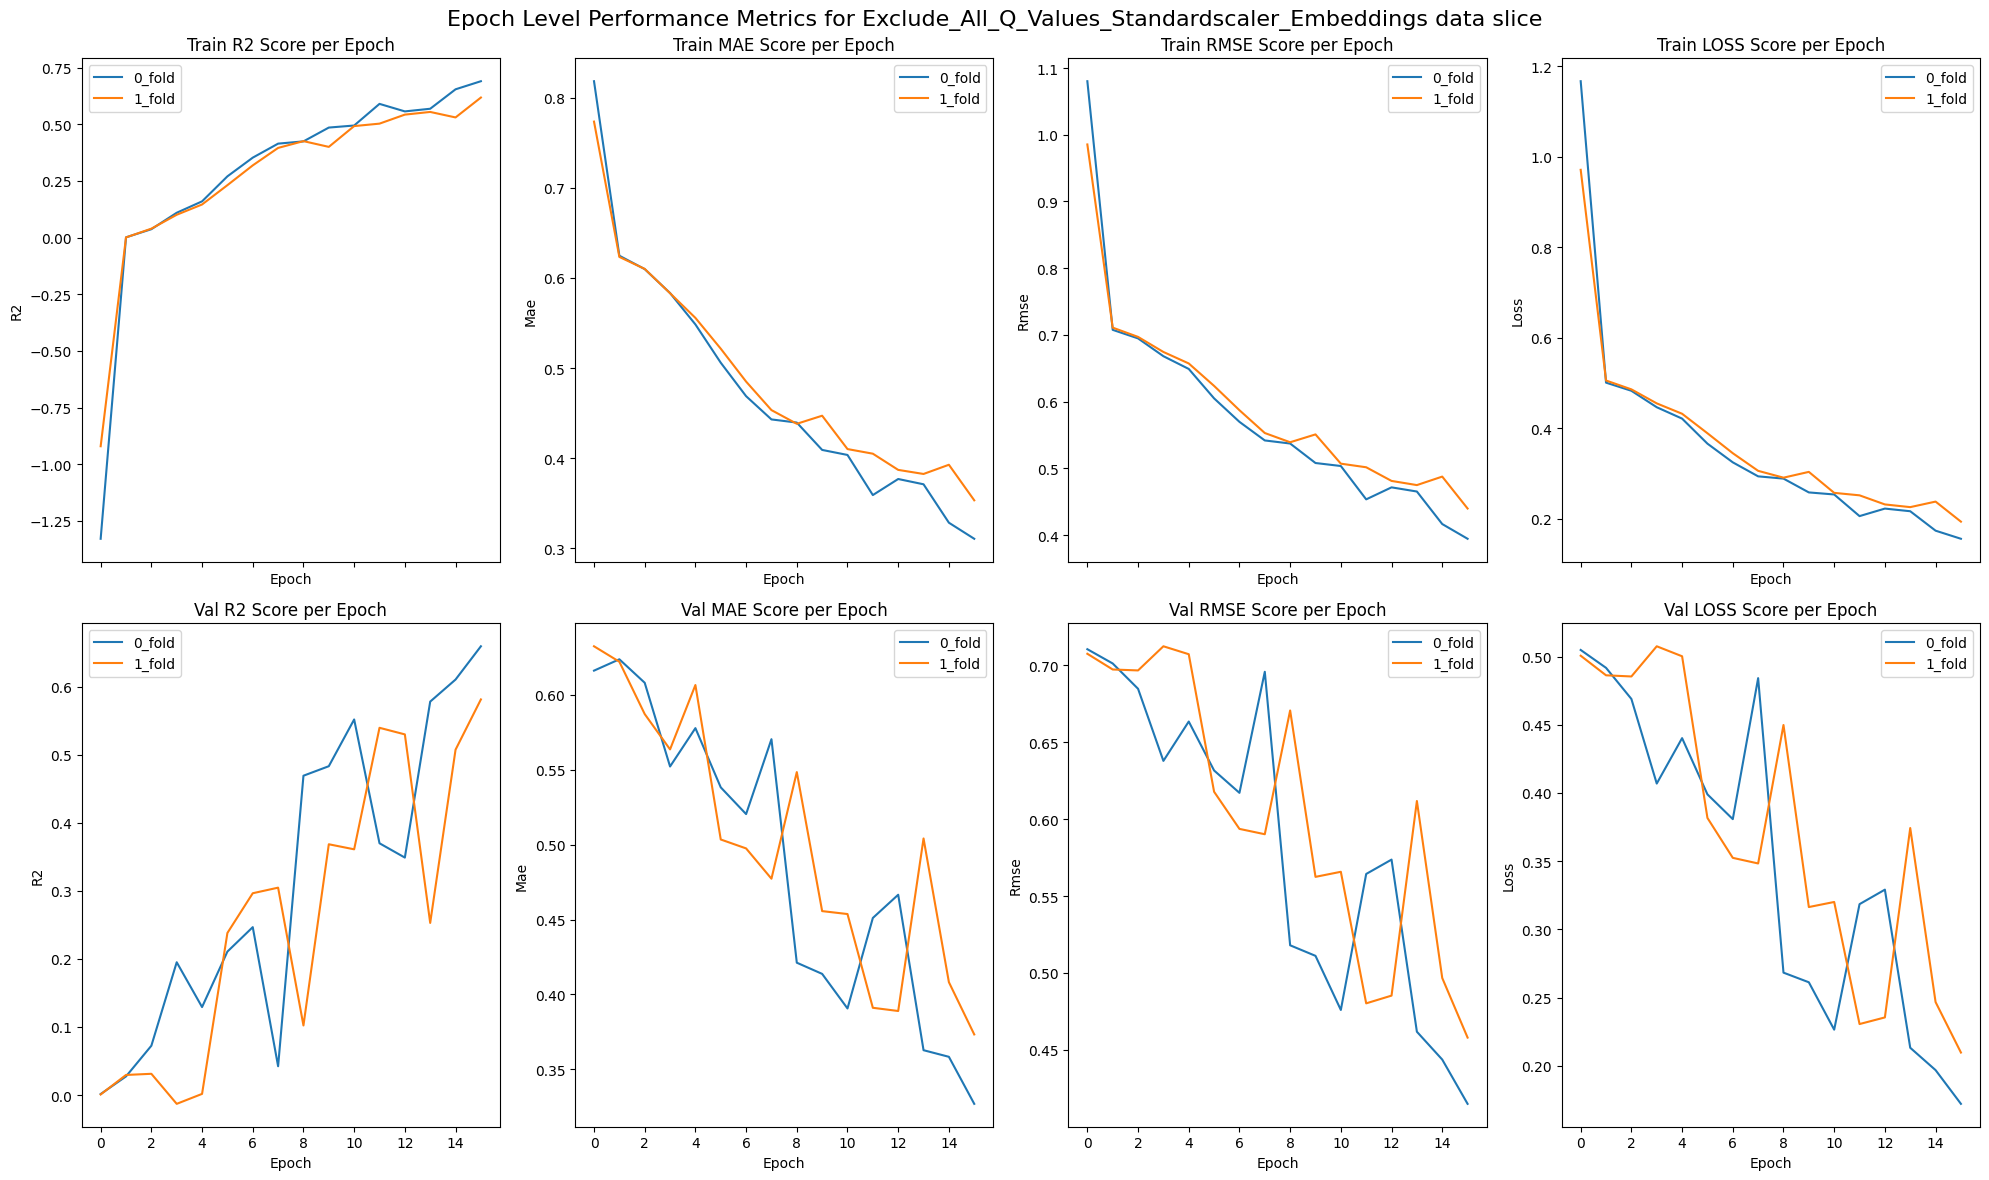

In [68]:
for k, v in model_results.items():
    
    CreatePlots.epoch_performance_per_fold(model_results = {k:v})

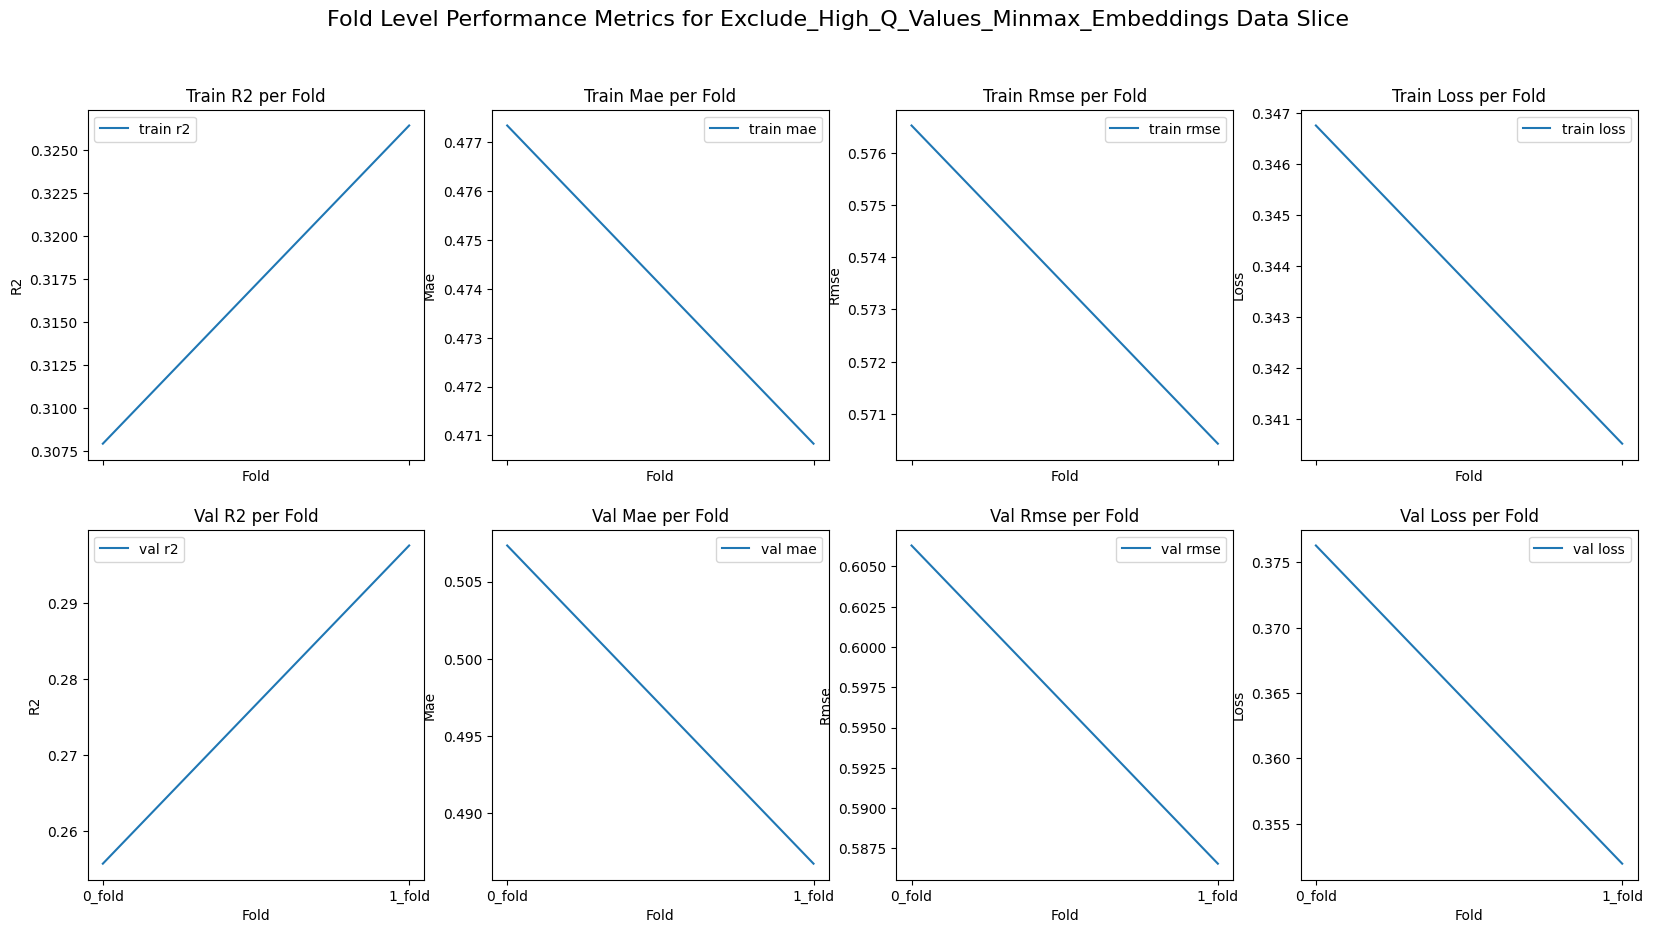

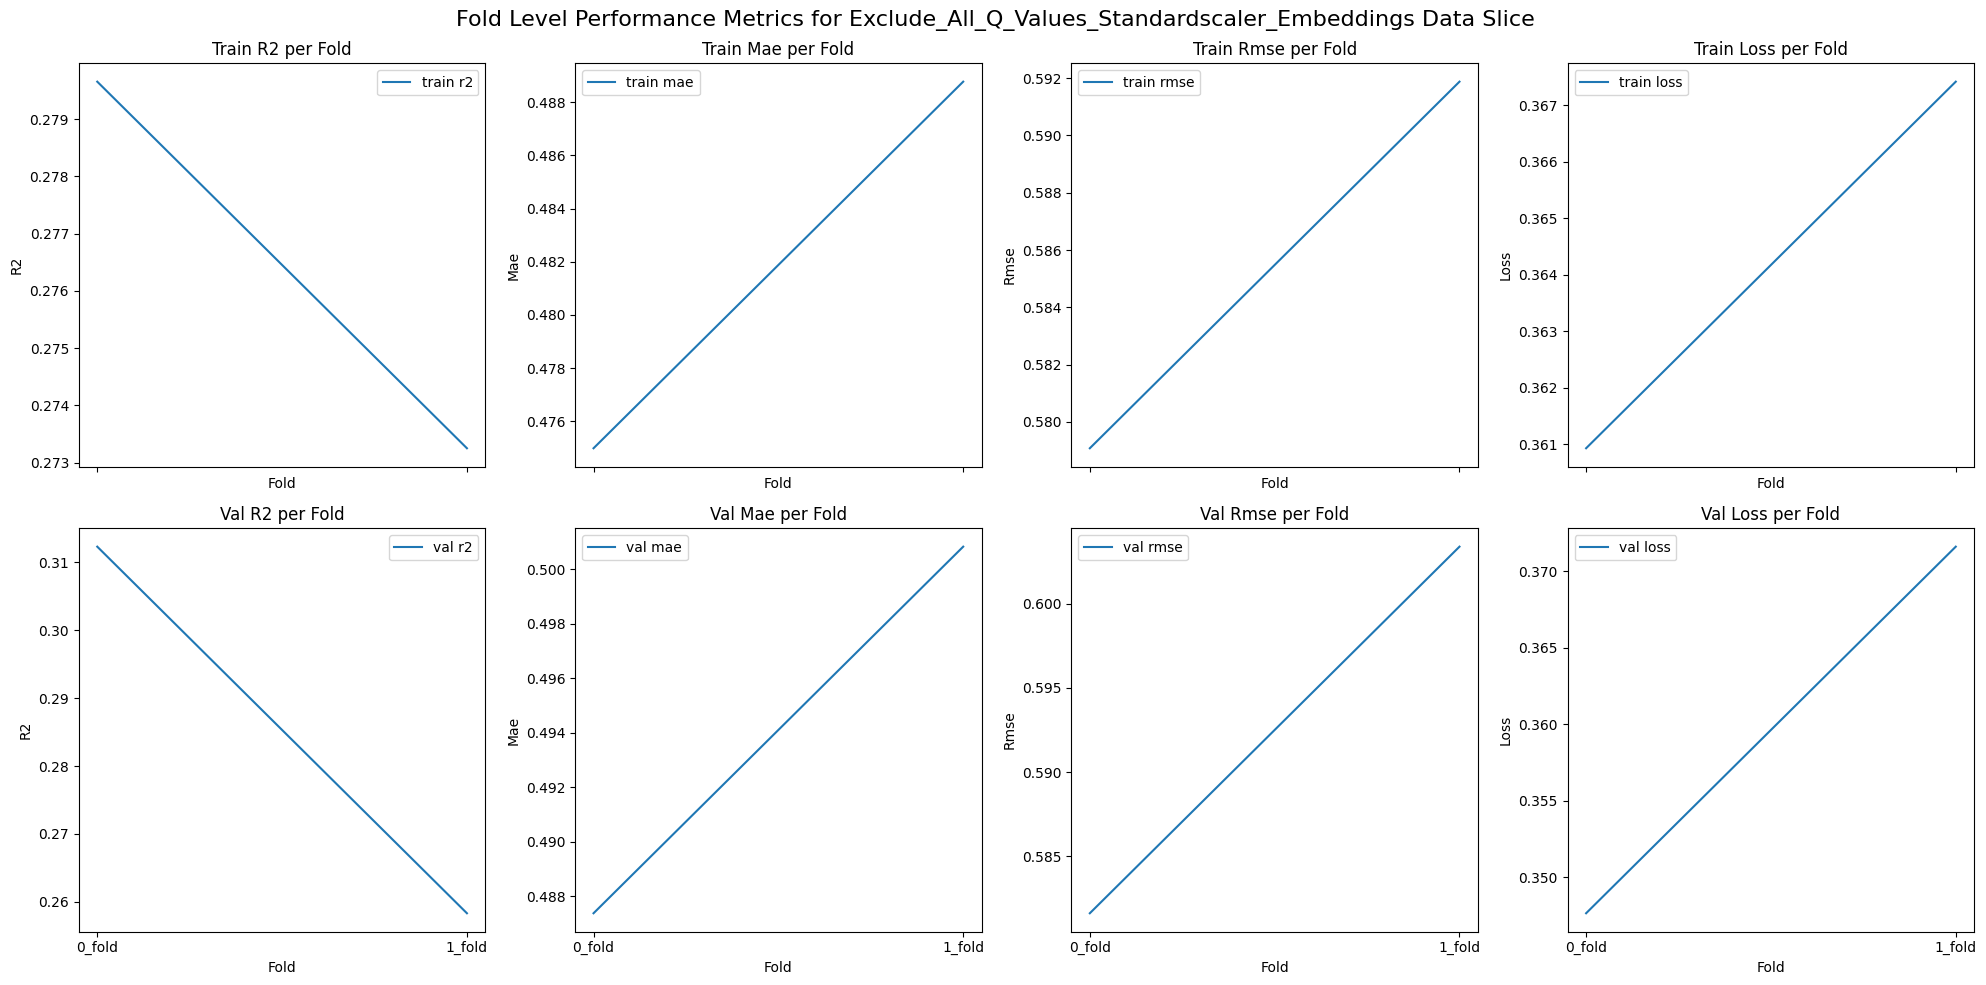

In [69]:
CreatePlots.fold_level_performance(avg_score_per_fold = avg_score_per_fold)

It looks like the model is potentially overfitting and is having a hard time learning the features to predict. Lets see if we can improve the scores by using the AA frequency scores with the StandardScaler. 
Performance with the one hot encoding vs embeddings is fairly similar so we'll have to test this again with the AA features. 

****

Run 3) CNN Model with Embeddings, Amino Acid frequencies and No Dropout

In [ ]:
#Define the model name
model_name = "ProteinCNN_Embedding_w_AA_No_Dropout"

sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = True
use_embedding= True
use_dropout = False
conv_dropout = 0.2

embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

#Optimizer
lr_rate = 0.001
L2_reg = 1e-5

#Model config dict for instantiating model during kfolds within training loop
model_config_dict = {
    'prediction_architecture': model_architectures.ProteinKd_CNN_Prediction,
    'sequence_length': encoded_sequence_length,  
    'num_additional_features': len(aa_values),  
    'use_aa_features': use_aa_features,
    'use_embedding': use_embedding,
    'use_dropout': use_dropout,
    'conv_dropout': conv_dropout,
    'embedding_dimension': embedding_dimension,
    'conv_layer_kernel_size': conv_layer_kernel_size,
    'pooling_kernel_size': pooling_kernel_size,
    'pool_stride': pool_stride,
    'conv_stride': conv_stride,
    'conv_padding': conv_padding,
    'conv_dilation': conv_dilation,
    'lr_rate': lr_rate,
    'L2_reg': L2_reg,
    'model_name' : model_name 
}

model, model_name, optimizer, loss_measurement, device = modelling_utilities.cnn_model_instantiation(model_config_dict)

print(model)

In [ ]:
sample_run  = {k:v for k,v in segmented_datasets_for_training.items() if k in ['exclude_high_q_values_MinMax_embeddings', 'exclude_all_q_values_StandardScaler_embeddings']}
# Usage in your training loop:


kfold_structure = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
model_results = training_loop(data_slices = sample_run,
                                                    num_epochs =num_epochs,
                                                    submitted_model = model,
                                                    loss_measurement = loss_measurement,
                                                    optimizer = optimizer,
                                                    device = device,
                                                    batch_size = batch_size, 
                                                    use_cross_val = True, 
                                                    random_seed = random_seed,
                                                    kfold_structure = kfold_structure, 
                                                    patience = patience,
                                                    n_folds = n_folds, 
                                                    model_name = model_name, 
                                                    model_config_dict = model_config_dict)

In [ ]:
avg_score_per_fold, avg_score_per_metric, max_score_per_metric = modelling_utilities.post_process_epoch_metrics(model_results)
print(max_score_per_metric, f' ---- max scores across all folds per metric {model_name}'

In [ ]:
CreatePlots = PlottingAssistance(n_folds = n_folds, metrics =['r2', 'mae', 'rmse', 'loss'])


In [ ]:
for k, v in model_results.items():
    
    CreatePlots.epoch_performance_per_fold(model_results = {k:v})

In [ ]:
CreatePlots.fold_level_performance(avg_score_per_fold = avg_score_per_fold)

Scores still aren't improving. Lets try using Dropout to improve performance

In [ ]:
#Define the model name
model_name = "ProteinCNN_Embedding_w_AA_w_Dropout"

sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = True
use_embedding= True
use_dropout = True
conv_dropout = 0.2

embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

#Optimizer
lr_rate = 0.001
L2_reg = 1e-5

#Model config dict for instantiating model during kfolds within training loop
model_config_dict = {
    'prediction_architecture': model_architectures.ProteinKd_CNN_Prediction,
    'sequence_length': encoded_sequence_length,  
    'num_additional_features': len(aa_values),  
    'use_aa_features': use_aa_features,
    'use_embedding': use_embedding,
    'use_dropout': use_dropout,
    'conv_dropout': conv_dropout,
    'embedding_dimension': embedding_dimension,
    'conv_layer_kernel_size': conv_layer_kernel_size,
    'pooling_kernel_size': pooling_kernel_size,
    'pool_stride': pool_stride,
    'conv_stride': conv_stride,
    'conv_padding': conv_padding,
    'conv_dilation': conv_dilation,
    'lr_rate': lr_rate,
    'L2_reg': L2_reg,
    'model_name' : model_name 
}

model, model_name, optimizer, loss_measurement, device = modelling_utilities.cnn_model_instantiation(model_config_dict)


In [ ]:
batch_size = 64
n_folds = 5
num_epochs = 10

sample_run  = {'exclude_all_q_values_StandardScaler_embeddings':segmented_datasets_for_training['exclude_all_q_values_StandardScaler_embeddings']}
# Usage in your training loop:
early_stopping = modelling_utilities.EarlyStopping(patience=10, verbose=True, path='model_checkpoint.pt')
kfold_structure = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

model_resutls = training_loop(data_slices = sample_run,
                                                    num_epochs =num_epochs,
                                                    submitted_model = model,
                                                    loss_measurement = loss_measurement,
                                                    optimizer = optimizer,
                                                    device = device,
                                                    batch_size = batch_size, 
                                                    use_cross_val = True, 
                                                    random_seed = random_seed,
                                                    kfold_structure = kfold_structure, 
                                                    patience = patience,
                                                    n_folds = n_folds)

In [ ]:
avg_score_per_fold, avg_score_per_metric, max_score_per_metric = modelling_utilities.post_process_epoch_metrics(model_results)
print(max_score_per_metric, f' ---- max scores across all folds per metric {model_name}'

In [ ]:
CreatePlots = PlottingAssistance(n_folds = n_folds, metrics =['r2', 'mae', 'rmse', 'loss'])

In [ ]:
for k, v in model_results.items():
    
    CreatePlots.epoch_performance_per_fold(model_results = {k:v})
    

In [ ]:
CreatePlots.fold_level_performance(avg_score_per_fold = avg_score_per_fold)

Overfitting remains an issue, lets try to increase dropout and use batch normalizaion to try to imprve

*****

Run 4) OverFitting Controls
    - Can we improve our model using batch normalization and overfitting. 

In [ ]:
#Define the model name
model_name = "ProteinCNN_Embedding_no_AA_w_Dropout"

sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = False
use_embedding= True
use_dropout = True
conv_dropout = 0.3 #Increased drop out
use_batch_norm = True

embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

#Optimizer
lr_rate = 0.001
L2_reg = 1e-5


#Model config dict for instantiating model during kfolds within training loop
model_config_dict = {
    'prediction_architecture': model_architectures.ProteinKd_CNN_Prediction,
    'sequence_length': encoded_sequence_length,  
    'num_additional_features': len(aa_values),  
    'use_aa_features': use_aa_features,
    'use_embedding': use_embedding,
    'use_dropout': use_dropout,
    'conv_dropout': conv_dropout,
    'embedding_dimension': embedding_dimension,
    'conv_layer_kernel_size': conv_layer_kernel_size,
    'pooling_kernel_size': pooling_kernel_size,
    'pool_stride': pool_stride,
    'conv_stride': conv_stride,
    'conv_padding': conv_padding,
    'conv_dilation': conv_dilation,
    'lr_rate': lr_rate,
    'L2_reg': L2_reg,
    'model_name' : model_name 
}

model, model_name, optimizer, loss_measurement, device = modelling_utilities.cnn_model_instantiation(model_config_dict)


In [ ]:
batch_size = 64
n_folds = 5
num_epochs = 10

sample_run  = {'exclude_all_q_values_StandardScaler_embeddings':segmented_datasets_for_training['exclude_all_q_values_StandardScaler_embeddings']}
# Usage in your training loop:
early_stopping = modelling_utilities.EarlyStopping(patience=10, verbose=True, path='model_checkpoint.pt')
kfold_structure = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

model_results = training_loop(data_slices = sample_run,
                                                    num_epochs =num_epochs,
                                                    submitted_model = model,
                                                    loss_measurement = loss_measurement,
                                                    optimizer = optimizer,
                                                    device = device,
                                                    batch_size = batch_size, 
                                                    use_cross_val = True, 
                                                    random_seed = random_seed,
                                                    kfold_structure = kfold_structure, 
                                                    patience = patience, 
                                                    n_folds = n_folds)

In [ ]:
sample_run.keys()

In [ ]:
avg_score_per_fold, avg_score_per_metric, max_score_per_metric = modelling_utilities.post_process_epoch_metrics(model_results)
print(max_score_per_metric, f' ---- max scores across all folds per metric {model_name}')

In [ ]:
CreatePlots = PlottingAssistance(n_folds = n_folds, metrics =['r2', 'mae', 'rmse', 'loss'])

In [ ]:
for k, v in model_results.items():
    
    CreatePlots.epoch_performance_per_fold(model_results = {k:v})

In [ ]:
CreatePlots.fold_level_performance(avg_score_per_fold = avg_score_per_fold)

In [ ]:
avg_score_per_fold

### HyperParameter Tuning
Tune the following: 
1) Conv kernel size - optional
2) Stride length - optional
3) dropout rate
4) lr rate
5) l2 reg
6) batch size

param_grid = {
    'lr_rate': [0.001, 0.01, 0.1],
    'L2_reg': [1e-5, 1e-4, 1e-3],
    'conv_layer_kernel_size': [3, 5, 7],
    'pooling_kernel_size': [2, 3],
    'batch_size': [32, 64, 128]
}

## Deeplearning baseline review indicates performance capping ~79-81% R2 val value. 
Improvements recommended: 
1) Increase drop out rate and co
2) Minimize CNN complexity (do not add more layers)
3) Add in a transformer architecture

In [ ]:
import torch
import torch.nn as nn

class ProteinKd_Prediction_CNN(nn.Module):
    def __init__(self, **kwargs):
        super(ProteinKd_Prediction, self).__init__()
        self.config(kwargs)
        if self.use_model_type == 'CNN':
            self.build_model_CNN(kwargs)
        elif self.use_model_type == 'CNN_Transformer':
            self.build_model_CNN_Transformer(kwargs)
        else:
            raise ValueError("Model type not supported")

    def build_model_CNN_Transformer(self, kwargs):
        # CNN Part
        if self.use_embedding:
            self.embedding = nn.Embedding(num_embeddings=20, embedding_dim=self.embed_dim)
            input_channels = self.embed_dim
        else:
            input_channels = self.num_channels
        
        if self.use_batch_norm:
            self.cnn_layers = nn.Sequential(
                nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=self.pool_kernel_size, stride=self.pool_stride)
            )
        else:
            self.cnn_layers = nn.Sequential(
                nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=self.pool_kernel_size, stride=self.pool_stride)
            )

        # Transformer Part
        transformer_model_layer = nn.TransformerEncoderLayer(
            d_model=128,  # This needs to match the output channels of the last CNN layer
            nhead=self.nheads,
            dim_feedforward=self.ffn_dim,
            dropout=self.dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_model_layer, num_layers=self.transformer_layers)

        # Combining additional features if any
        self.to_features = nn.Linear(128, self.features_dim)

        # Fully Connected Layers
        final_input_size = self.features_dim + (self.num_additional_features if self.use_aa_features else 0)
        self.fullyconnected = nn.Sequential(
            nn.Linear(final_input_size, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x, additional_features=None):
        if self.use_embedding:
            x = self.embedding(x)
            x = x.transpose(1, 2)  # Change shape to (batch, channels, sequence_length)
        
        x = self.cnn_layers(x)
        x = x.transpose(1, 2)  # Adjust shape for transformer (batch, seq_len, feature)
        
        x = self.transformer_encoder(x)

        # Assuming global average pooling over sequence dimension
        x = x.mean(dim=1)

        x = self.to_features(x)

        if self.use_aa_features and additional_features is not None:
            x = torch.cat((x, additional_features), dim=1)

        x = self.fullyconnected(x)
        x = x.squeeze()
        return x

    def config(self, kwargs):
        self.use_model_type = kwargs.get('use_model_type', "CNN")

        # CNN configuration
        self.sequence_length = kwargs.get('sequence_length', 246)
        self.embed_dim = kwargs.get('embed_dim', 64)
        self.use_embedding = kwargs.get('use_embedding', False)
        self.conv_kernel_size = kwargs.get('conv_kernel_size', 3)
        self.conv_stride = kwargs.get('conv_stride', 1)
        self.conv_padding = kwargs.get('conv_padding', 1)
        self.pool_kernel_size = kwargs.get('pool_kernel_size', 2)
        self.pool_stride = kwargs.get('pool_stride', 2)
        self.num_channels = kwargs.get('num_channels', 20)

        # Transformer configuration
        self.nheads = kwargs.get('nheads', 8)
        self.ffn_dim = kwargs.get('ffn_dim', 512)
        self.transformer_layers = kwargs.get('transformer_layers', 4)
        self.features_dim = kwargs.get('features_dim', 128)
        
        # Additional features
        self.use_aa_features = kwargs.get('use_aa_features', False)
        self.num_additional_features = kwargs.get('num_additional_features', 0)
        
        self.use_dropout = kwargs.get('use_dropout', False)
        self.dropout_rate = kwargs.get('dropout_rate', 0.5)
        self.use_batch_norm = kwargs.get('use_batch_norm', False)
        self.model_name = kwargs.get('model_name', 'ProteinKd_CNN_Transformer')

In [ ]:
#Define the model name
model_name = "ProteinCNN_Embedding_no_AA_w_Dropout"

sequence_length = encoded_sequence_length #dynamically determined
num_additional_features = len(aa_values)#dynamically determined
use_aa_features = False
use_embedding= True
use_dropout = True
conv_dropout = 0.2

embedding_dimension = 64
conv_layer_kernel_size = 3
pooling_kernel_size = 2
pool_stride = 2
conv_stride = 1
conv_padding = 1
conv_dilation = 1

nheads = 8
ffn_dim = 512
transformer_layers = 4
features_dim = 128

#Optimizer
lr_rate = 0.001
L2_reg = 1e-5

## Evaluation time: Lets see some plots
- Ideally we want to see all the training slices compared against each other on the same plots

